# Part 2 - Model Calibration

In [1]:
%autosave 60
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares
import warnings
warnings.filterwarnings('ignore')

Autosaving every 60 seconds


The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}

In [2]:
#SABR Volatility formula
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

> Now we will define a function to calculate the implied volatility using the market prices of options. We will use root finding method.

In [3]:
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

> In Model calibration we tune the parameters in such a way that the volatility from SABR model matches with the market implied volatility. We use least squares to minimize the errors

In [4]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0

    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

> Lets import the data and preprocess it 

In [5]:
#S&P500 index data
spx = pd.read_csv('Data/SPX_options.csv',
                  index_col=0,
                  parse_dates=True)

#SPDR S&P500 ETF data
spy = pd.read_csv('Data/SPY_options.csv',
                  index_col=0,
                  parse_dates=True)

#Discount rates
discount_rate = pd.read_csv('Data/zero_rates_20201201.csv',
                           index_col=0,
                           parse_dates=True)

In [6]:
def preprocessData(df):
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    return df

In [7]:
spx = preprocessData(spx)
spy = preprocessData(spy)

> Here we will define our option parameters such as strike, spot, forward price, discount rate etc.

> To calculate discount rate for our maturity period we have to linearly interpolate the data to get the desired rate.

In [8]:
discount_rate.head()

,days,rate
date,,
2020-12-01,7,0.102280
2020-12-01,13,0.114128
2020-12-01,49,0.216480
2020-12-01,77,0.220707
2020-12-01,104,0.219996


In [9]:
S = 3662.45 #Spot price

> Lets define a function which will calculate the market implied volatilities for respective maturities and try to calibrate our model using the functions that we have defined earlier. We will pass our processed dataframe, expiry date, Spot price, discount rate and forward price

In [10]:
def calibrate(df, exdate, S):
    #get the data for given expiry
    df = df[df['exdate'] == exdate]
    
    #calculate days to expiry
    days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
    T = days_to_expiry/365
    
    #calculate the discount rate
    
    r = np.interp(days_to_expiry, discount_rate['days'], discount_rate['rate'])
    
    #calculate implied volatilities from market data
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                      x['strike'],
                                                      r,
                                                      x['mid'],
                                                      T,
                                                      x['payoff']),
                                                      axis=1)
    df.dropna(inplace=True)
    
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    
    impliedvols = []
    for K in strikes: 
        try:
            if K > S:
                impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
            else:
                impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
        except IndexError:
            # Handle the case where the index is out of bounds
            impliedvols.append(None)

    #populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    df.ffill(inplace=True)
    
    #calculate the forward price for SABR
    F = S*np.exp(r*T)
    
    #calibrate the parameters to match the implied volatilities
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                                                  initialGuess)
    
    #print the tuned parameters
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    print('Calibrated SABR model parameters:')
    print('alpha = %.3f' %alpha)
    print('beta = %.1f' %beta)
    print('rho = %.3f' %rho)
    print('nu = %.3f' %nu)
    
    #plot the fitted volatility data
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))
        
    plt.figure(tight_layout=True,dpi=400)
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.title(f'Expiry {pd.Timestamp(str(exdate)).date()}')
    plt.legend()
    plt.show()
    
    return alpha, rho, nu, strikes

> We have 3 different maturities for spx option. Lets calibrate our model for all the three maturities.

In [11]:
spx['exdate'].value_counts()

exdate
20201218    822
20210115    738
20210219    512
Name: count, dtype: int64

Calibrated SABR model parameters:
alpha = 1.211
beta = 0.7
rho = -0.364
nu = 5.452


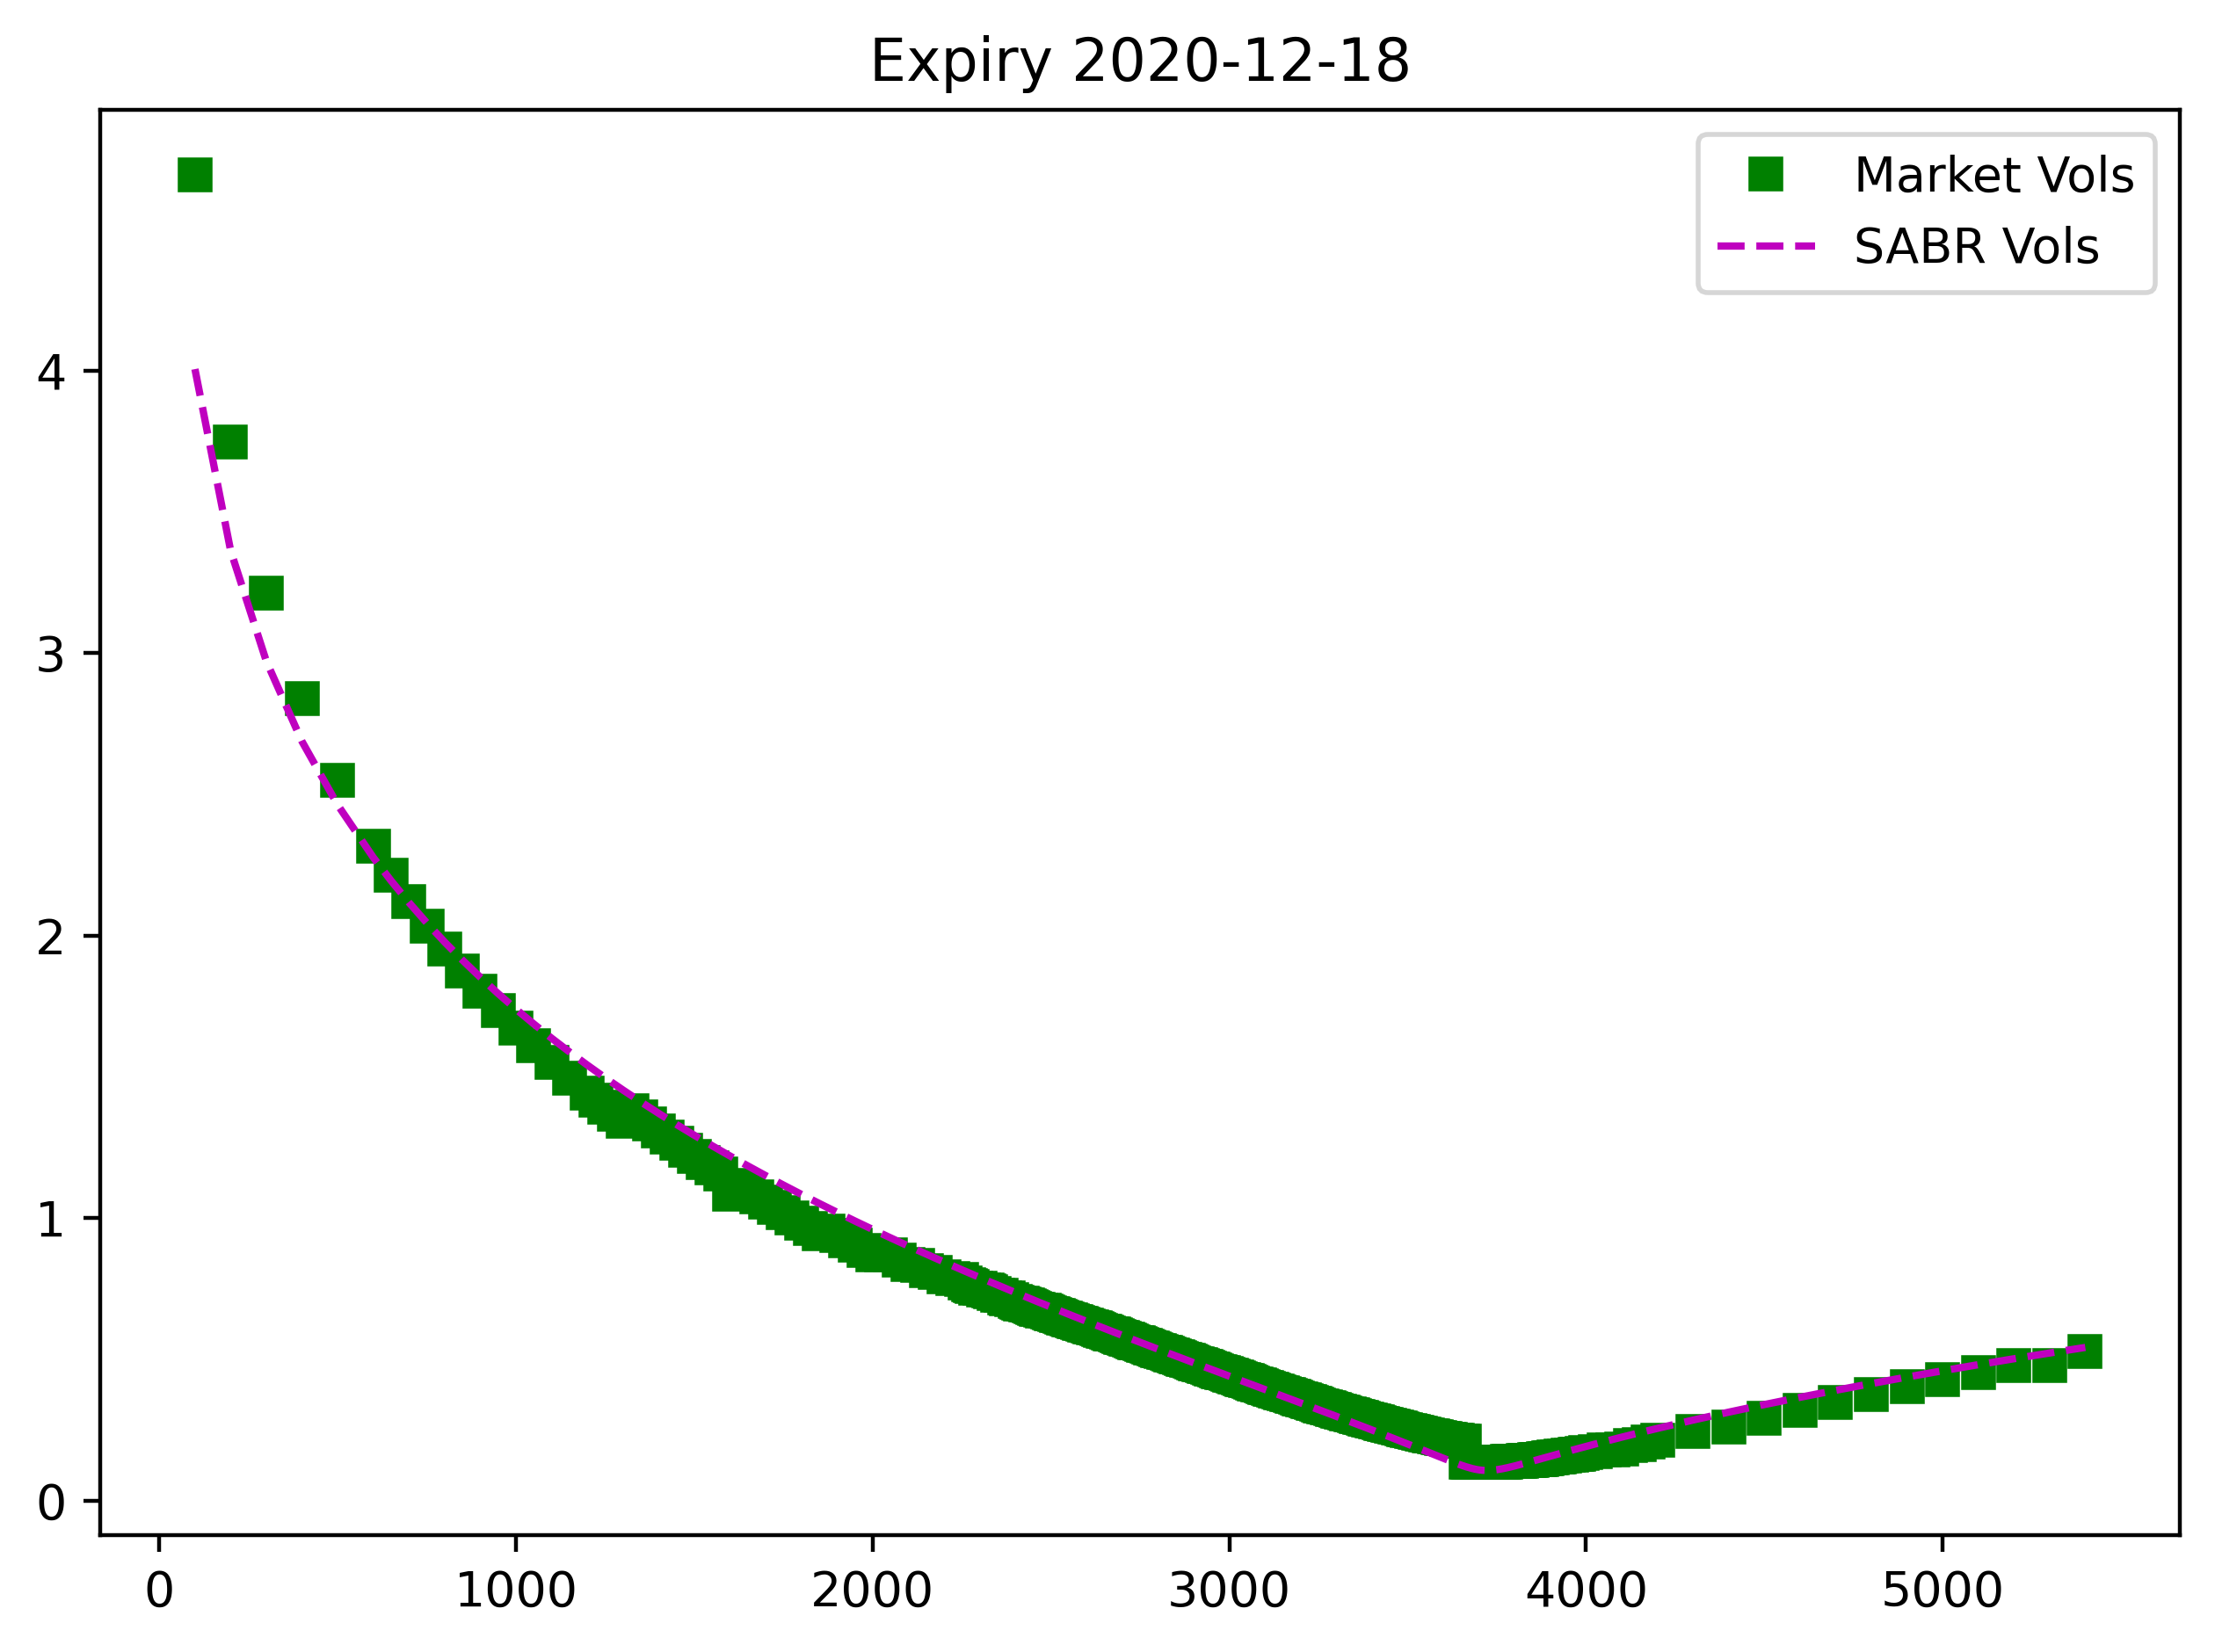

In [12]:
exdate = 20201218 #first expiry
alpha, rho, nu, strikes = calibrate(spx, exdate, S)

Calibrated SABR model parameters:
alpha = 1.725
beta = 0.7
rho = -0.667
nu = 2.862


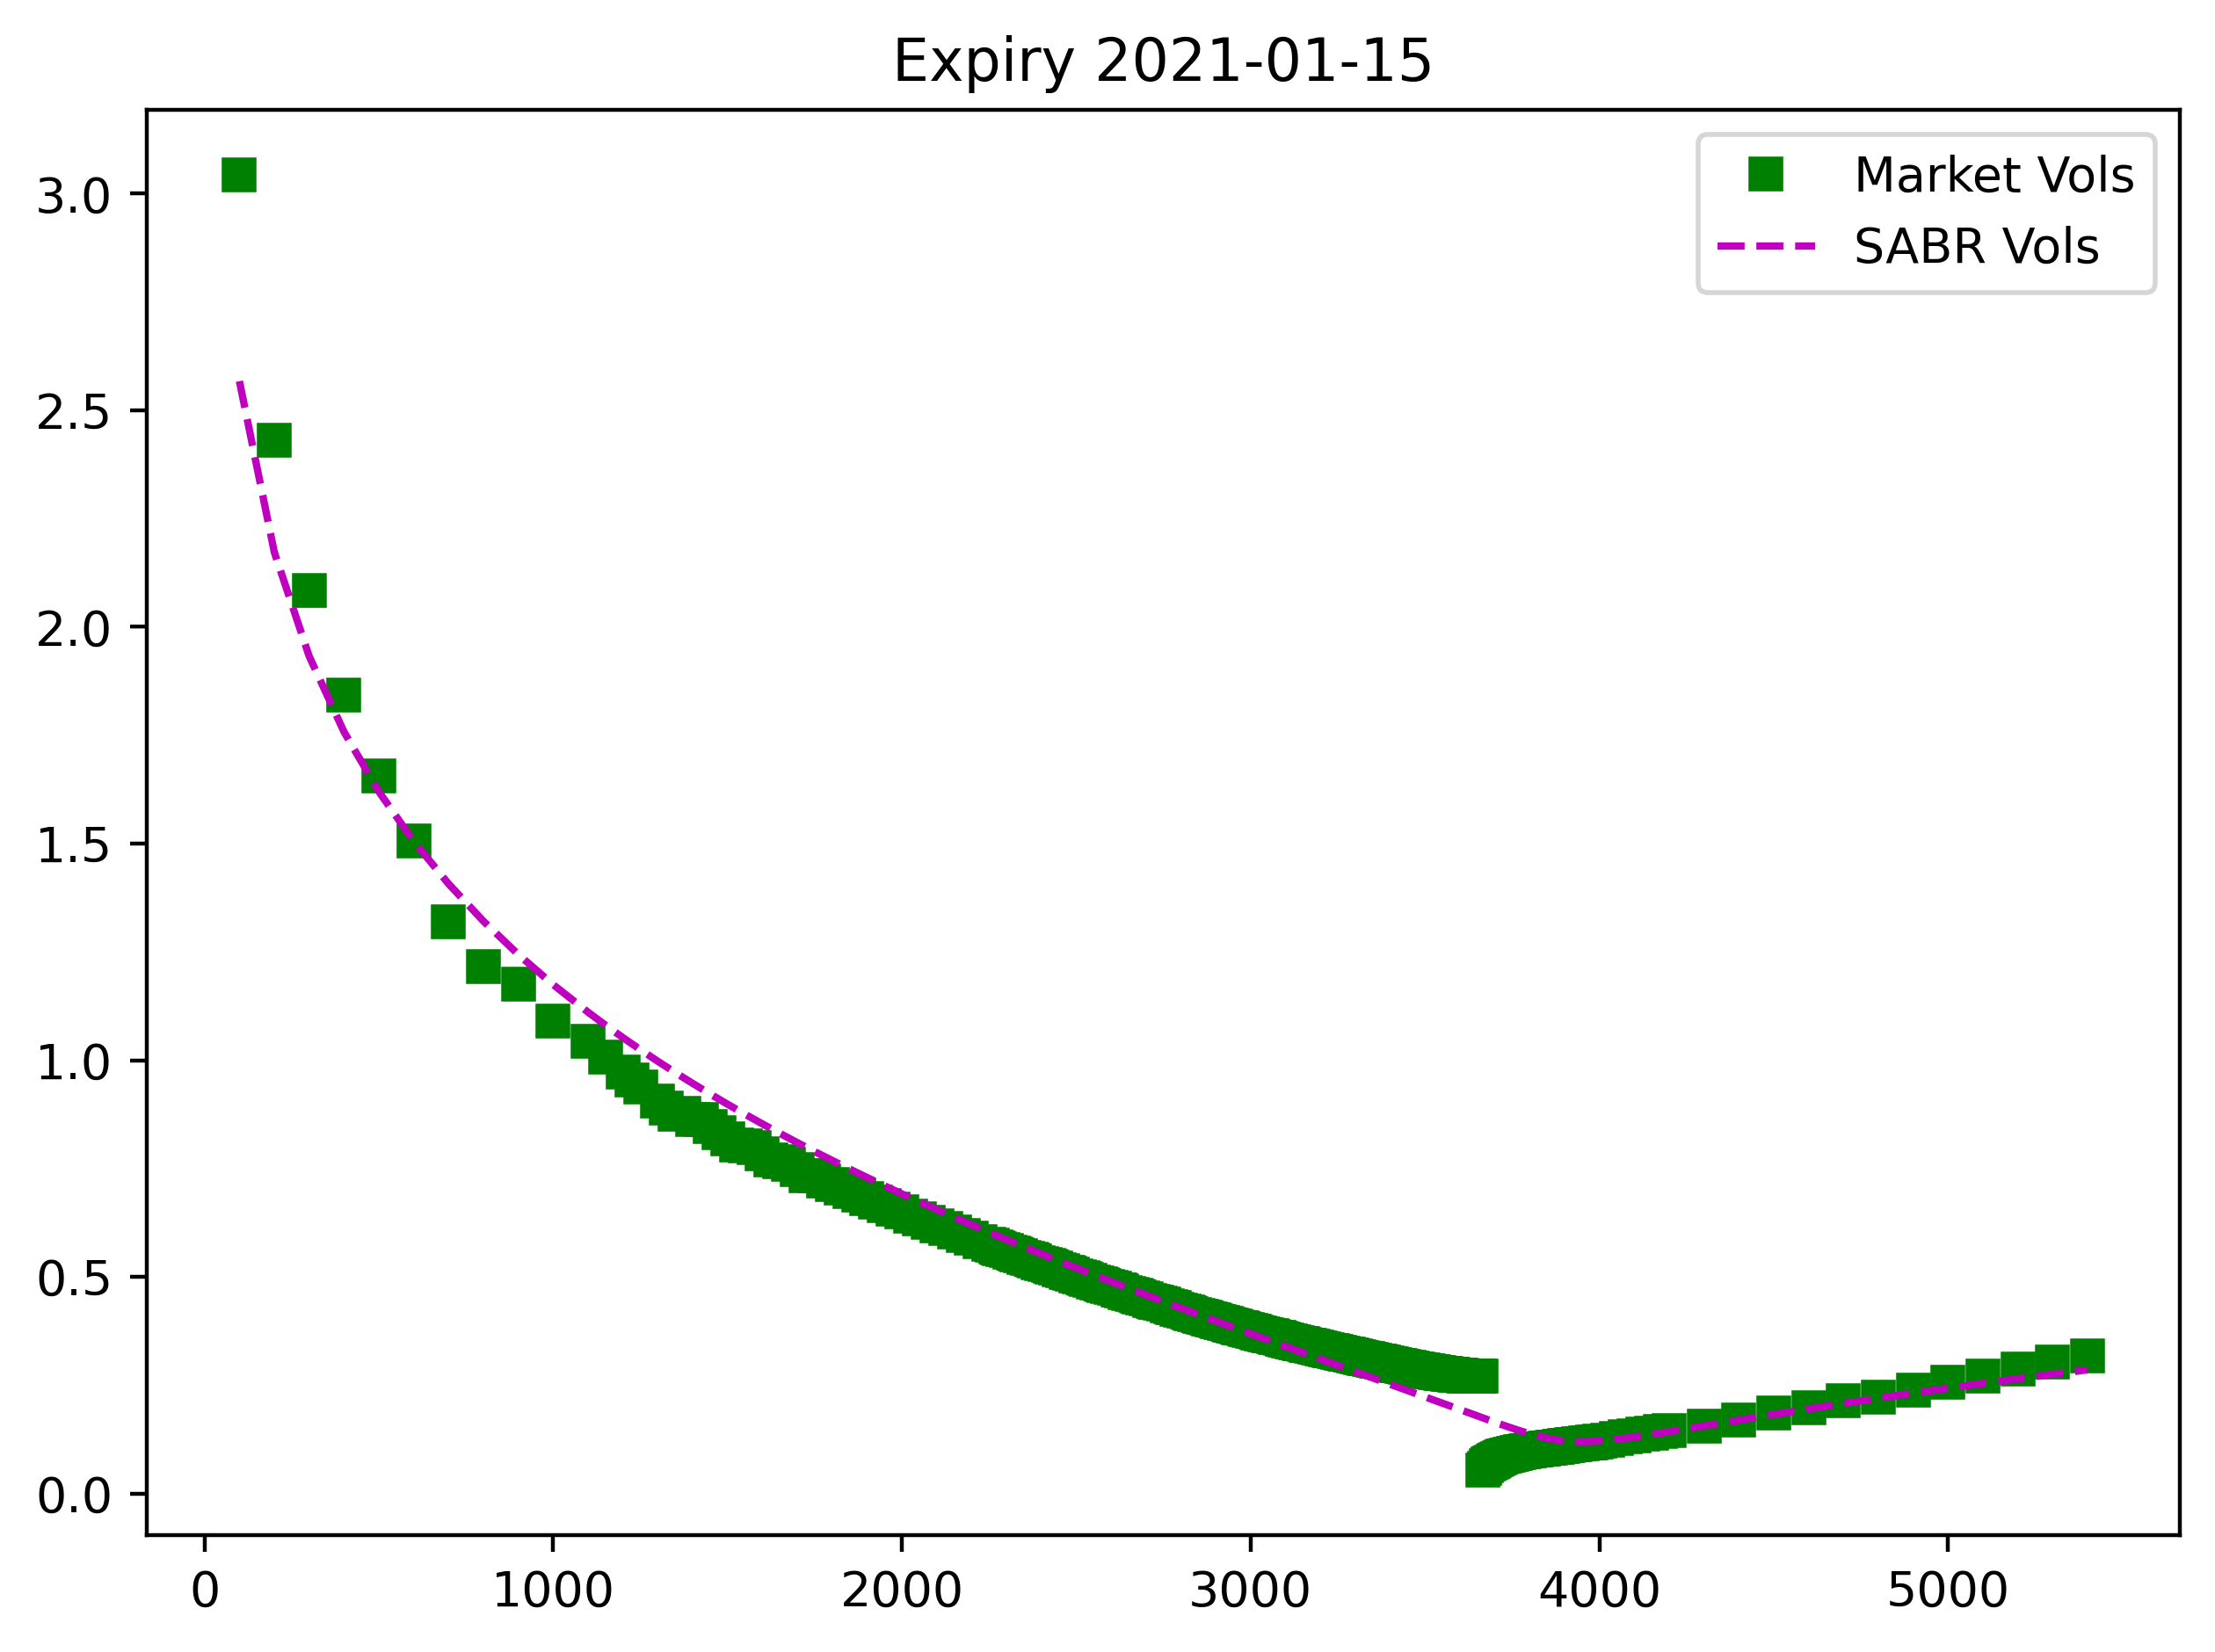

In [13]:
exdate = 20210115 #second expiry
alpha, rho, nu, strikes = calibrate(spx, exdate, S)

Calibrated SABR model parameters:
alpha = 2.272
beta = 0.7
rho = -0.851
nu = 1.844


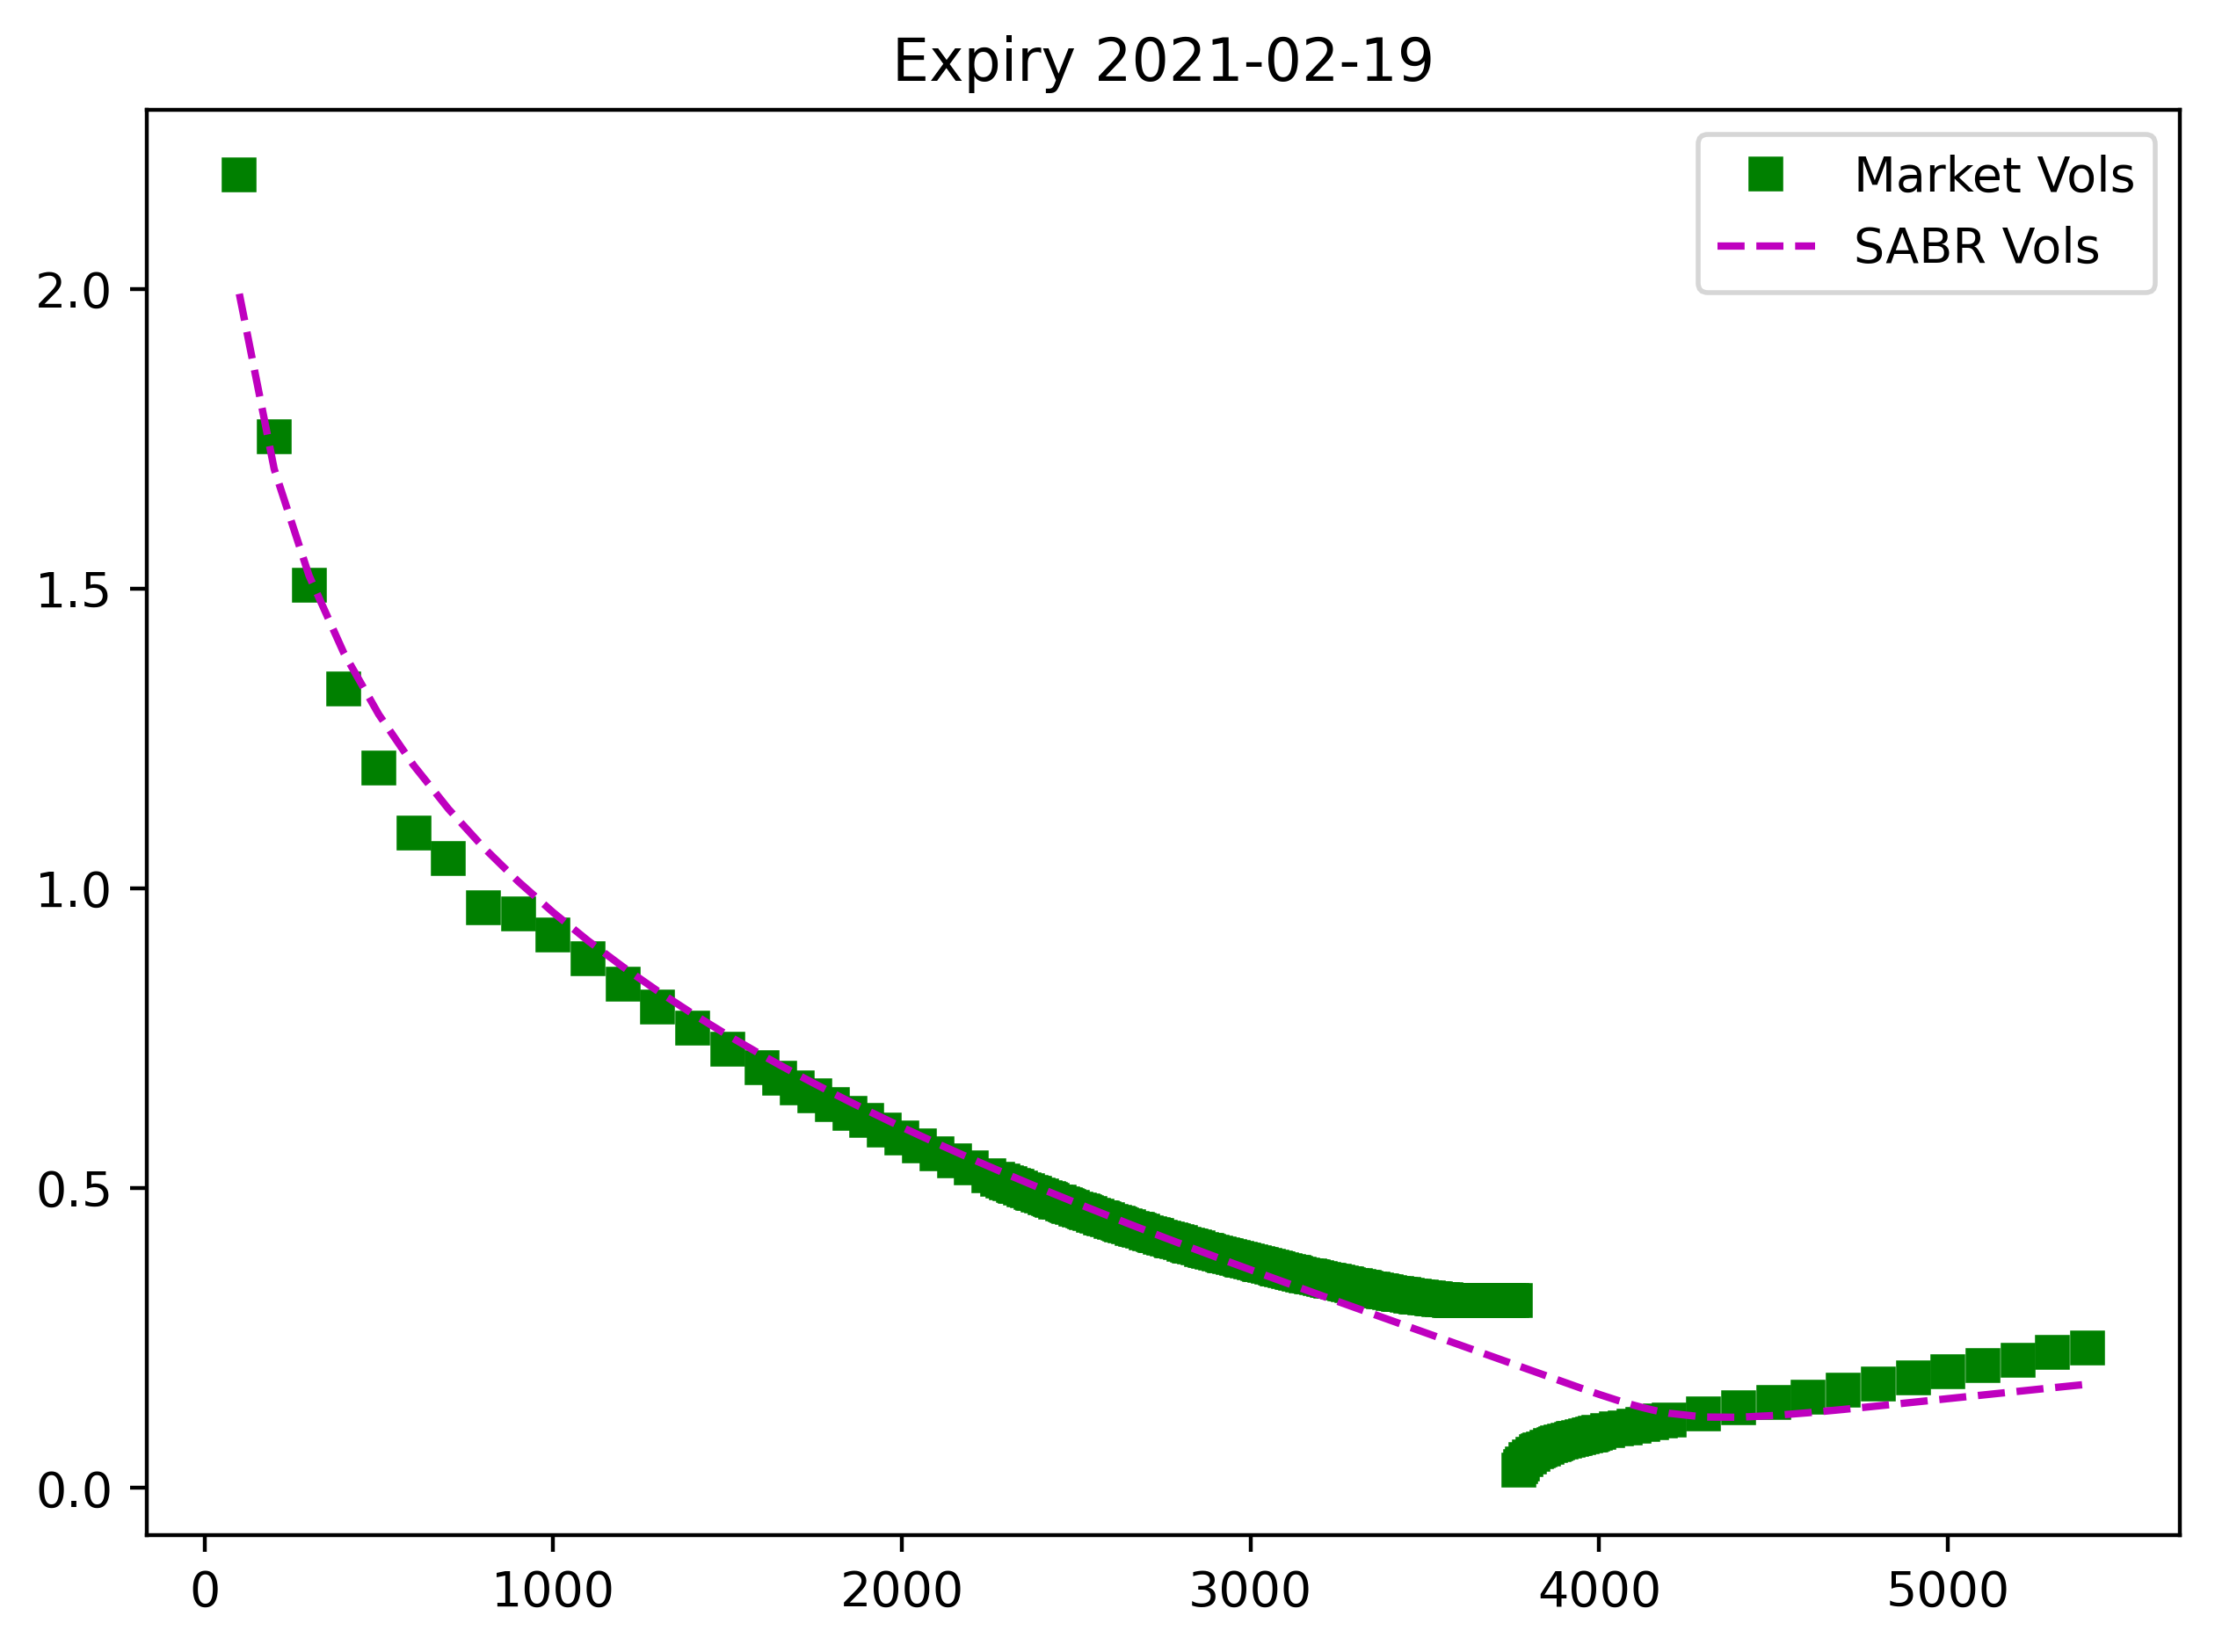

In [14]:
exdate = 20210219 #third expiry
alpha, rho, nu, strikes = calibrate(spx, exdate, S)

> Lets do the calibration using SPDR SPY ETF data. 

In [15]:
spy['exdate'].value_counts()

exdate
20210115    556
20201218    510
20210219    334
Name: count, dtype: int64

In [16]:
S = 366.02

Calibrated SABR model parameters:
alpha = 0.877
beta = 0.7
rho = -0.620
nu = 2.795


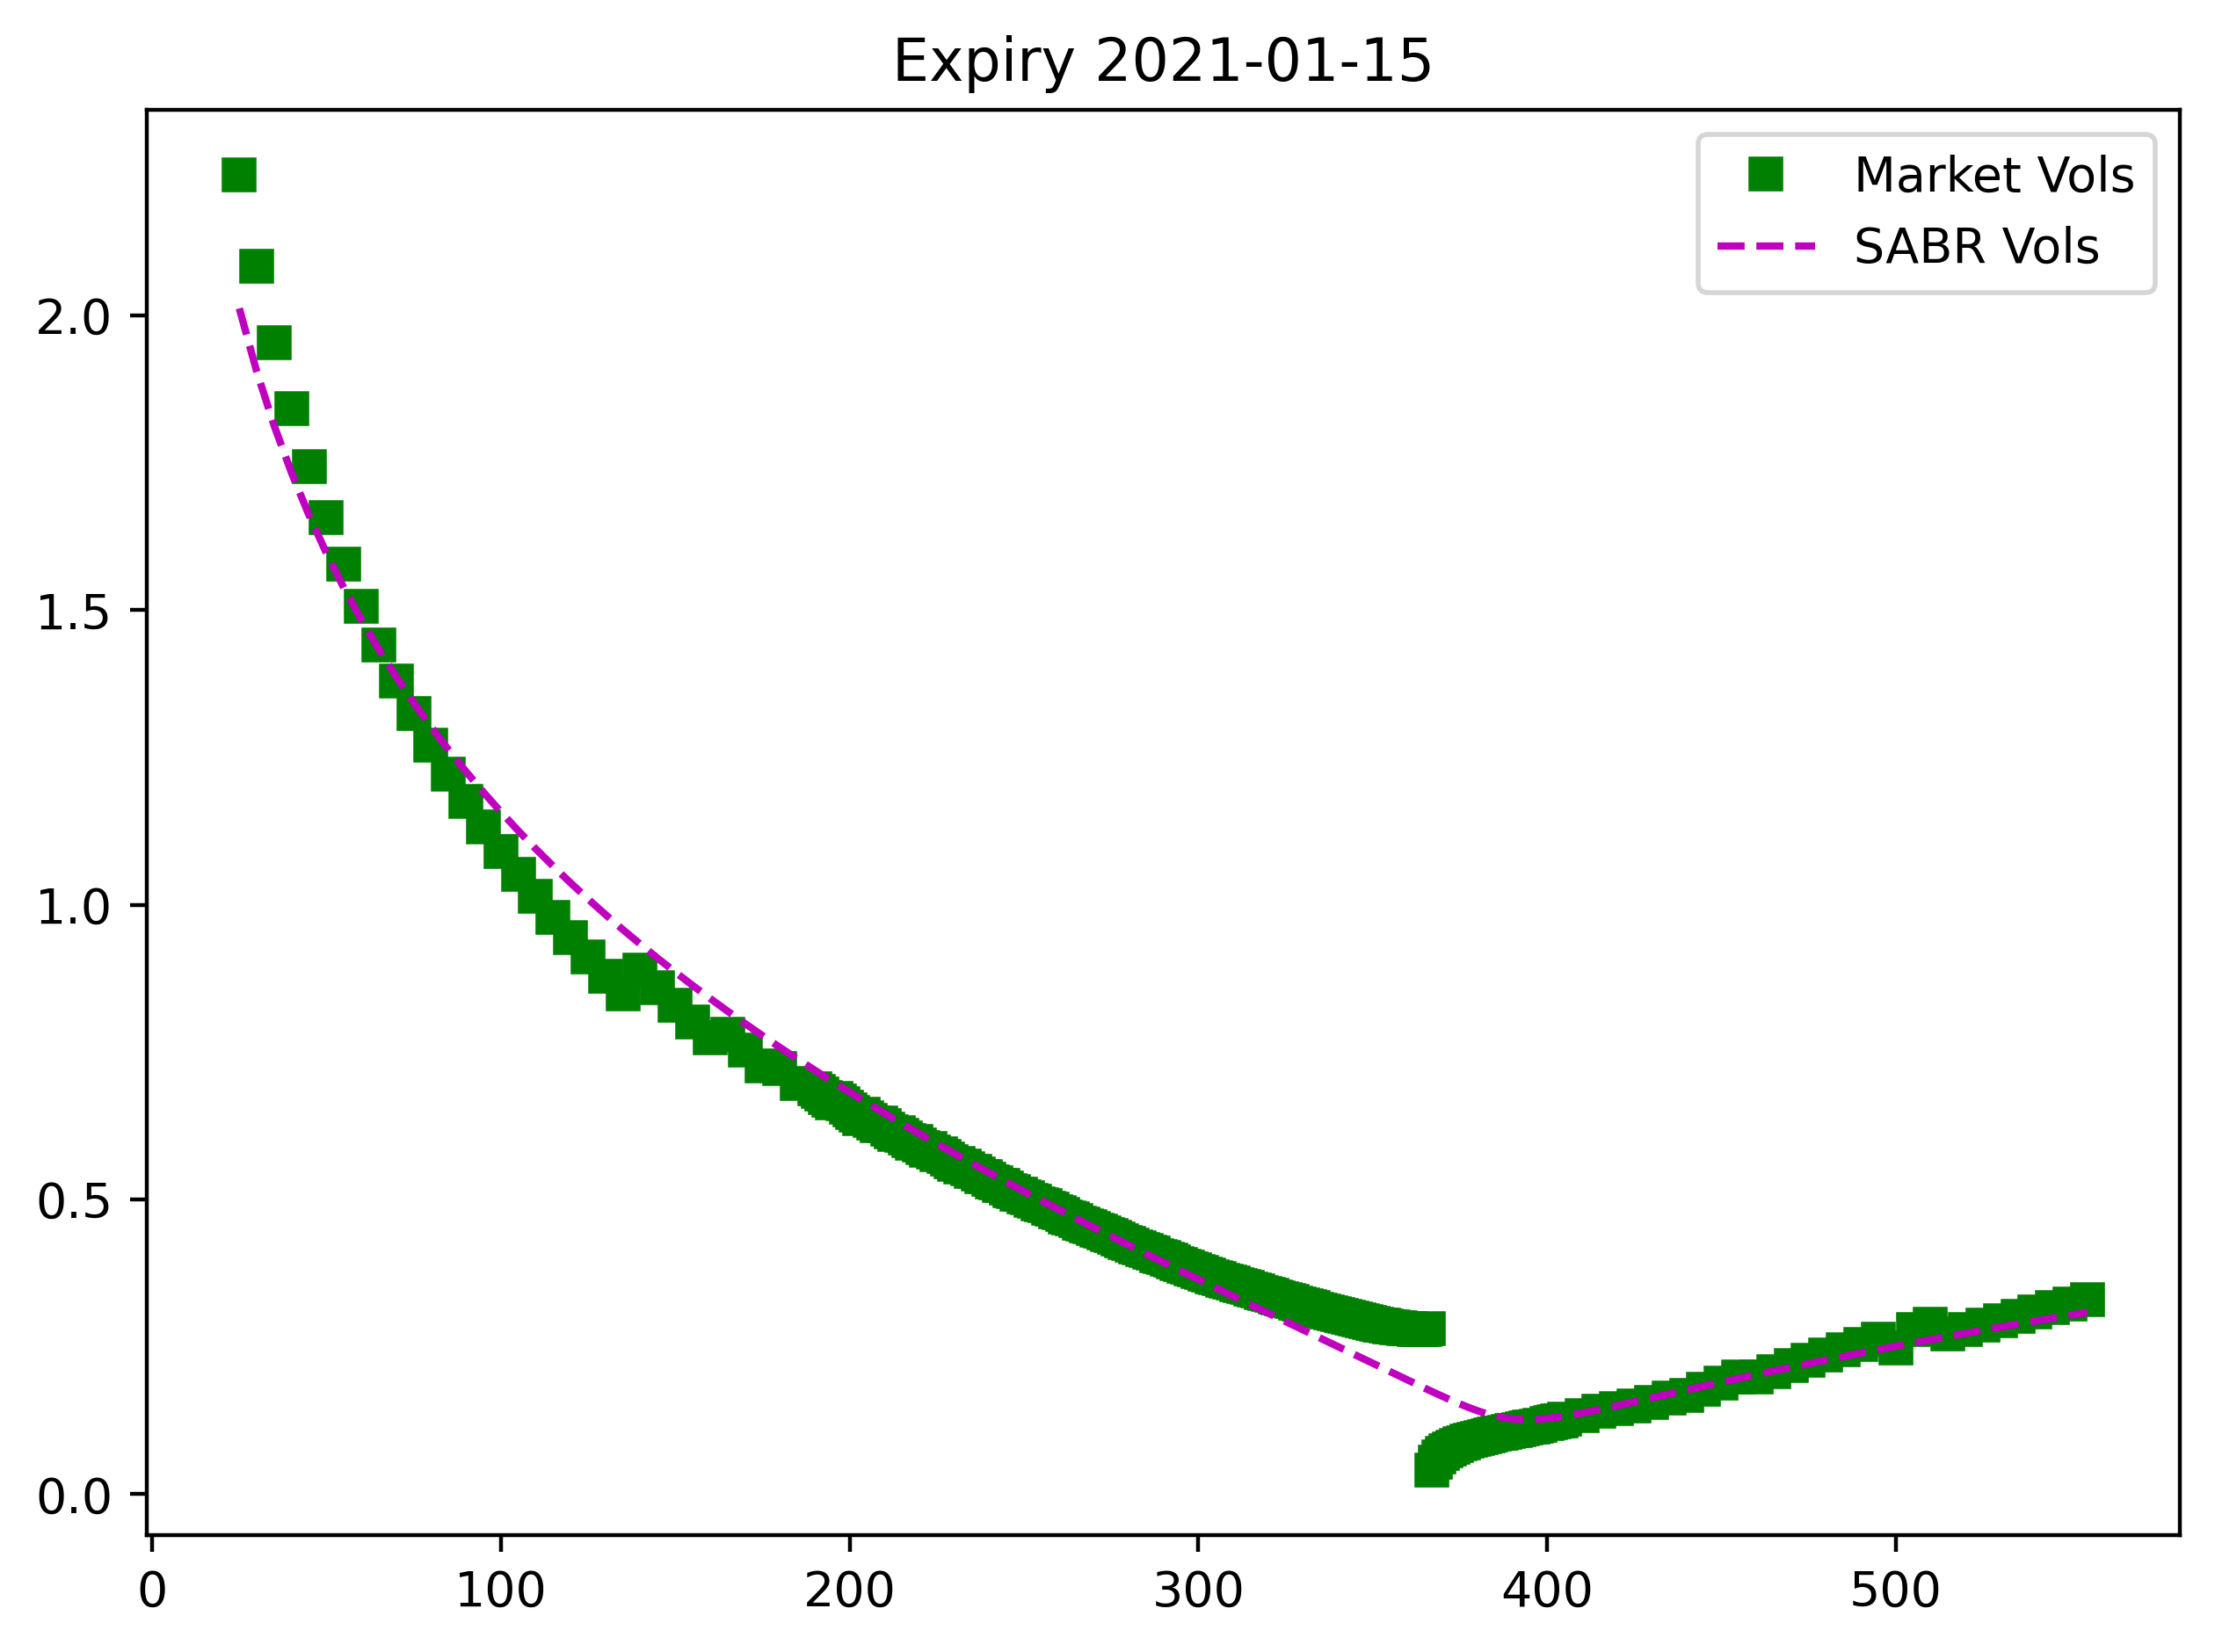

In [17]:
exdate = 20210115 #first expiry
alpha, rho, nu, strikes = calibrate(spy, exdate, S)

Calibrated SABR model parameters:
alpha = 0.670
beta = 0.7
rho = -0.452
nu = 5.245


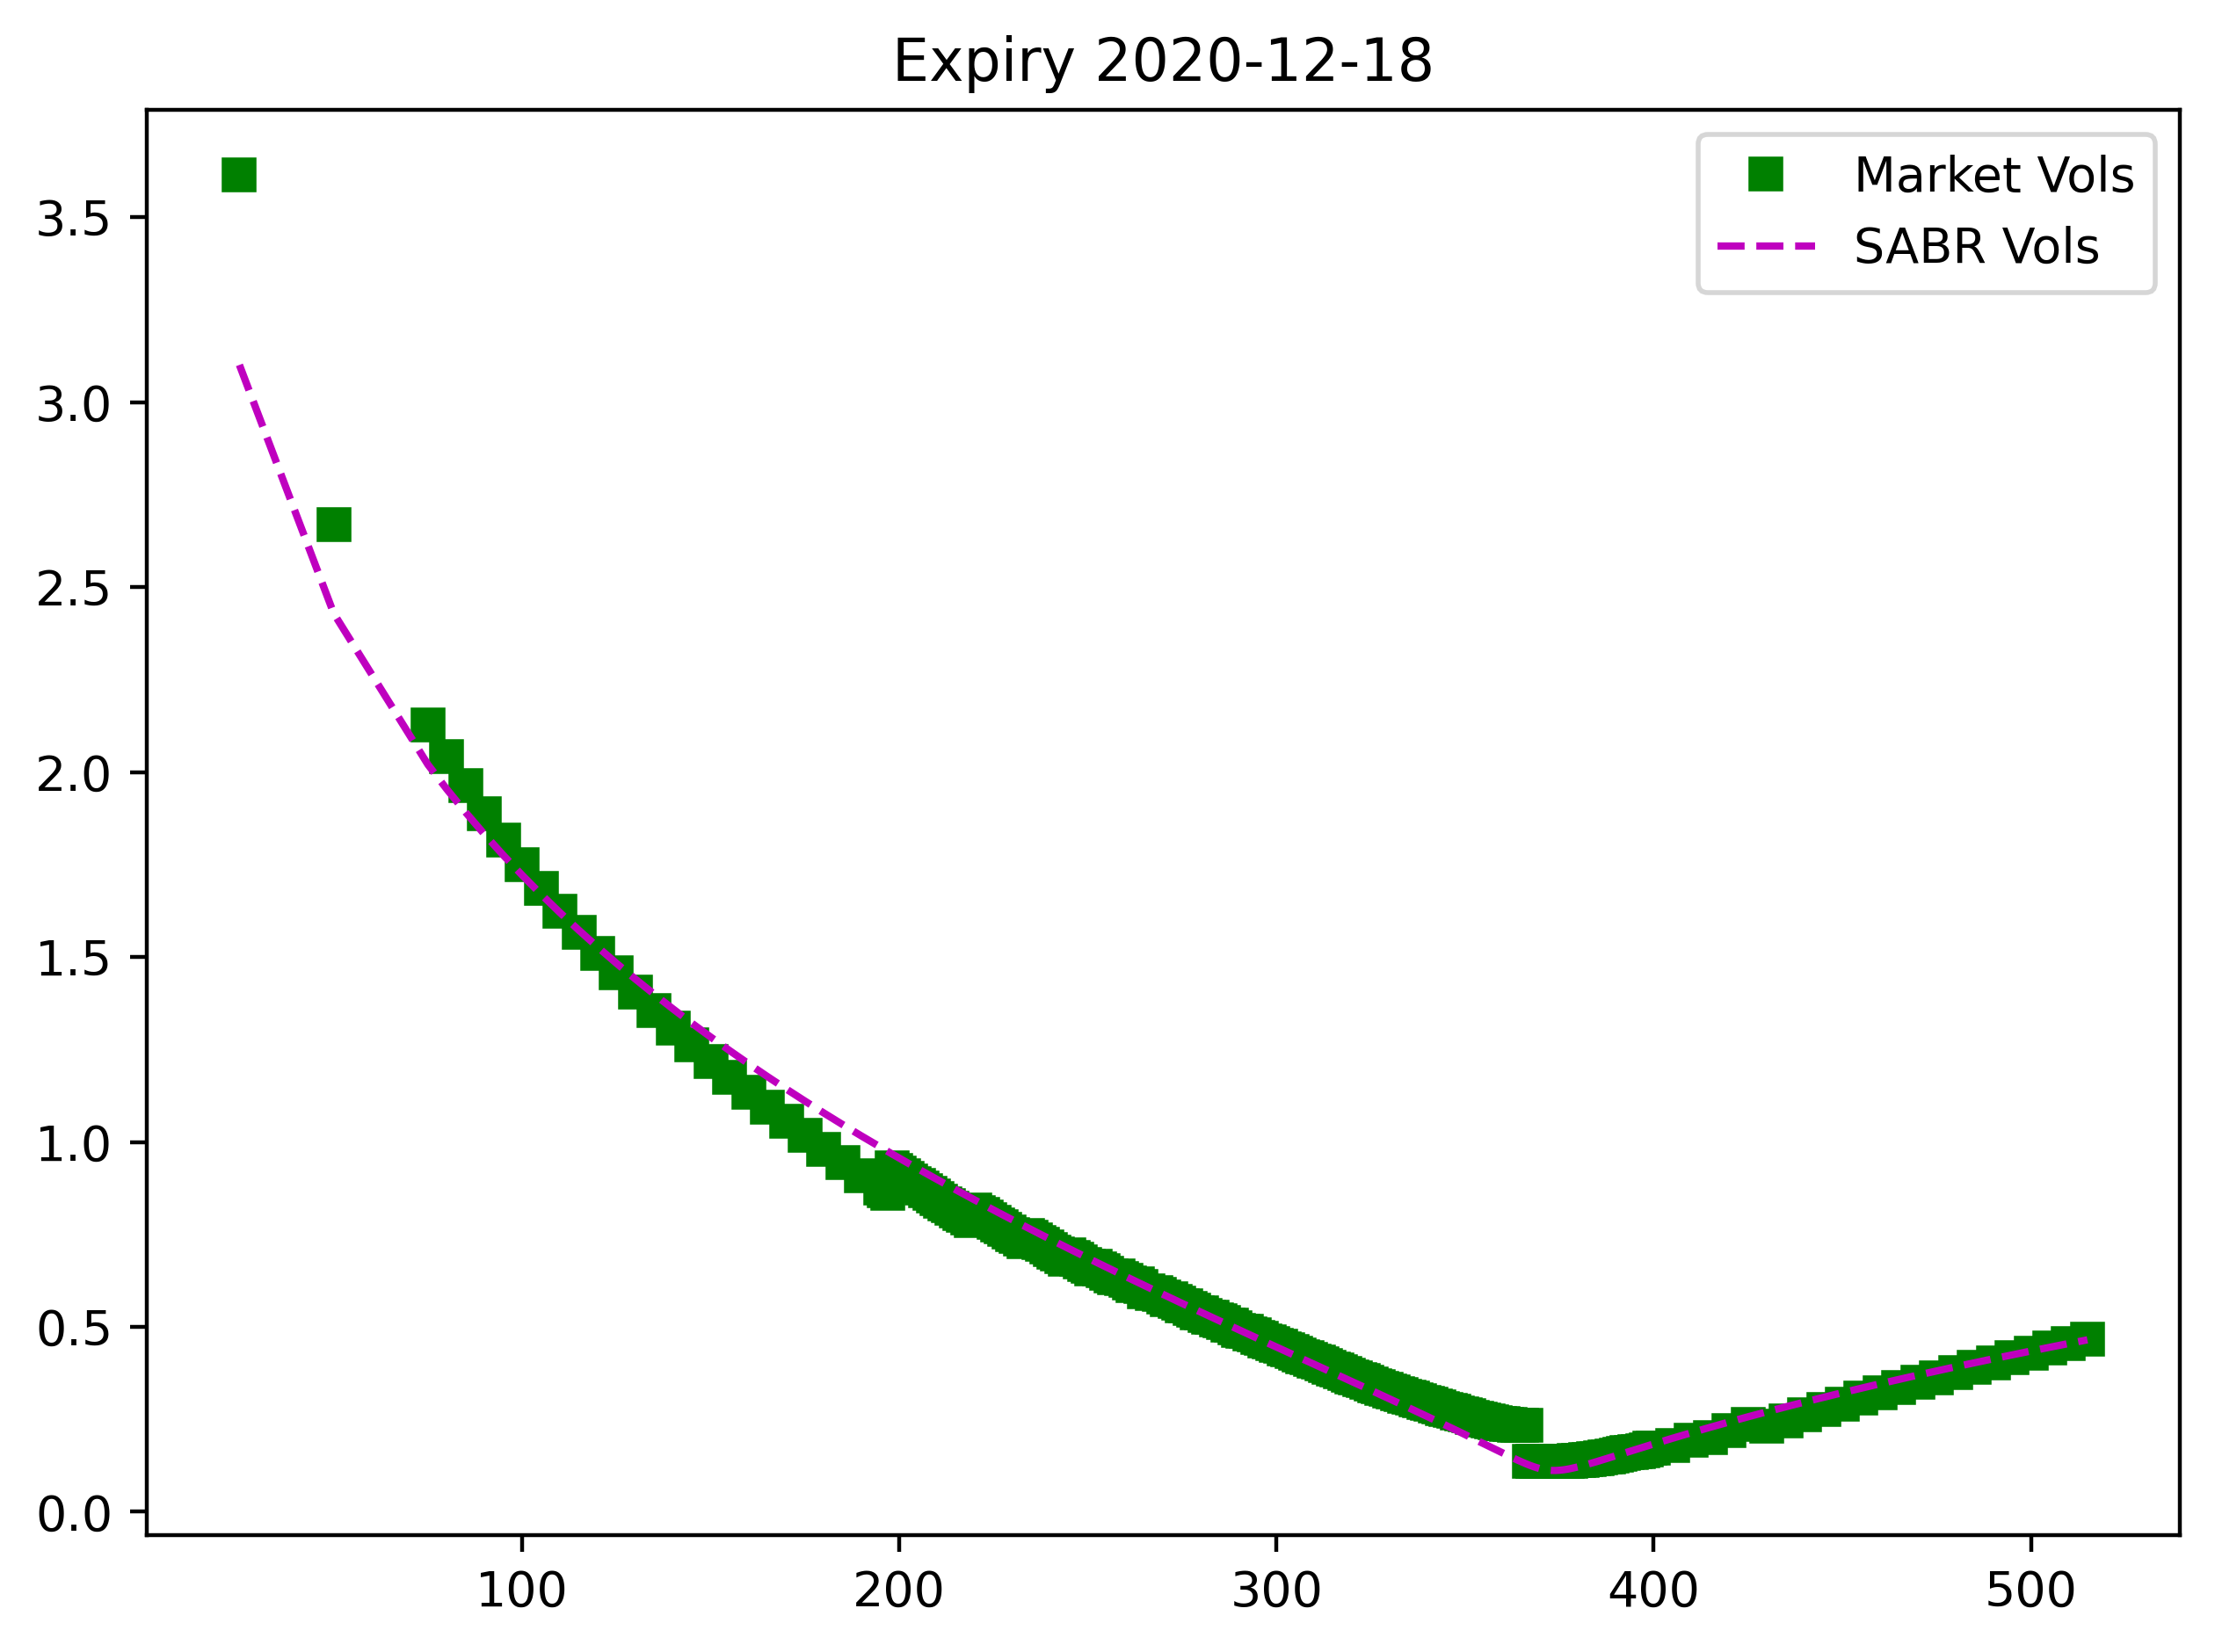

In [18]:
exdate = 20201218 #second expiry
alpha, rho, nu, strikes = calibrate(spy, exdate, S)

Calibrated SABR model parameters:
alpha = 1.154
beta = 0.7
rho = -0.846
nu = 1.940


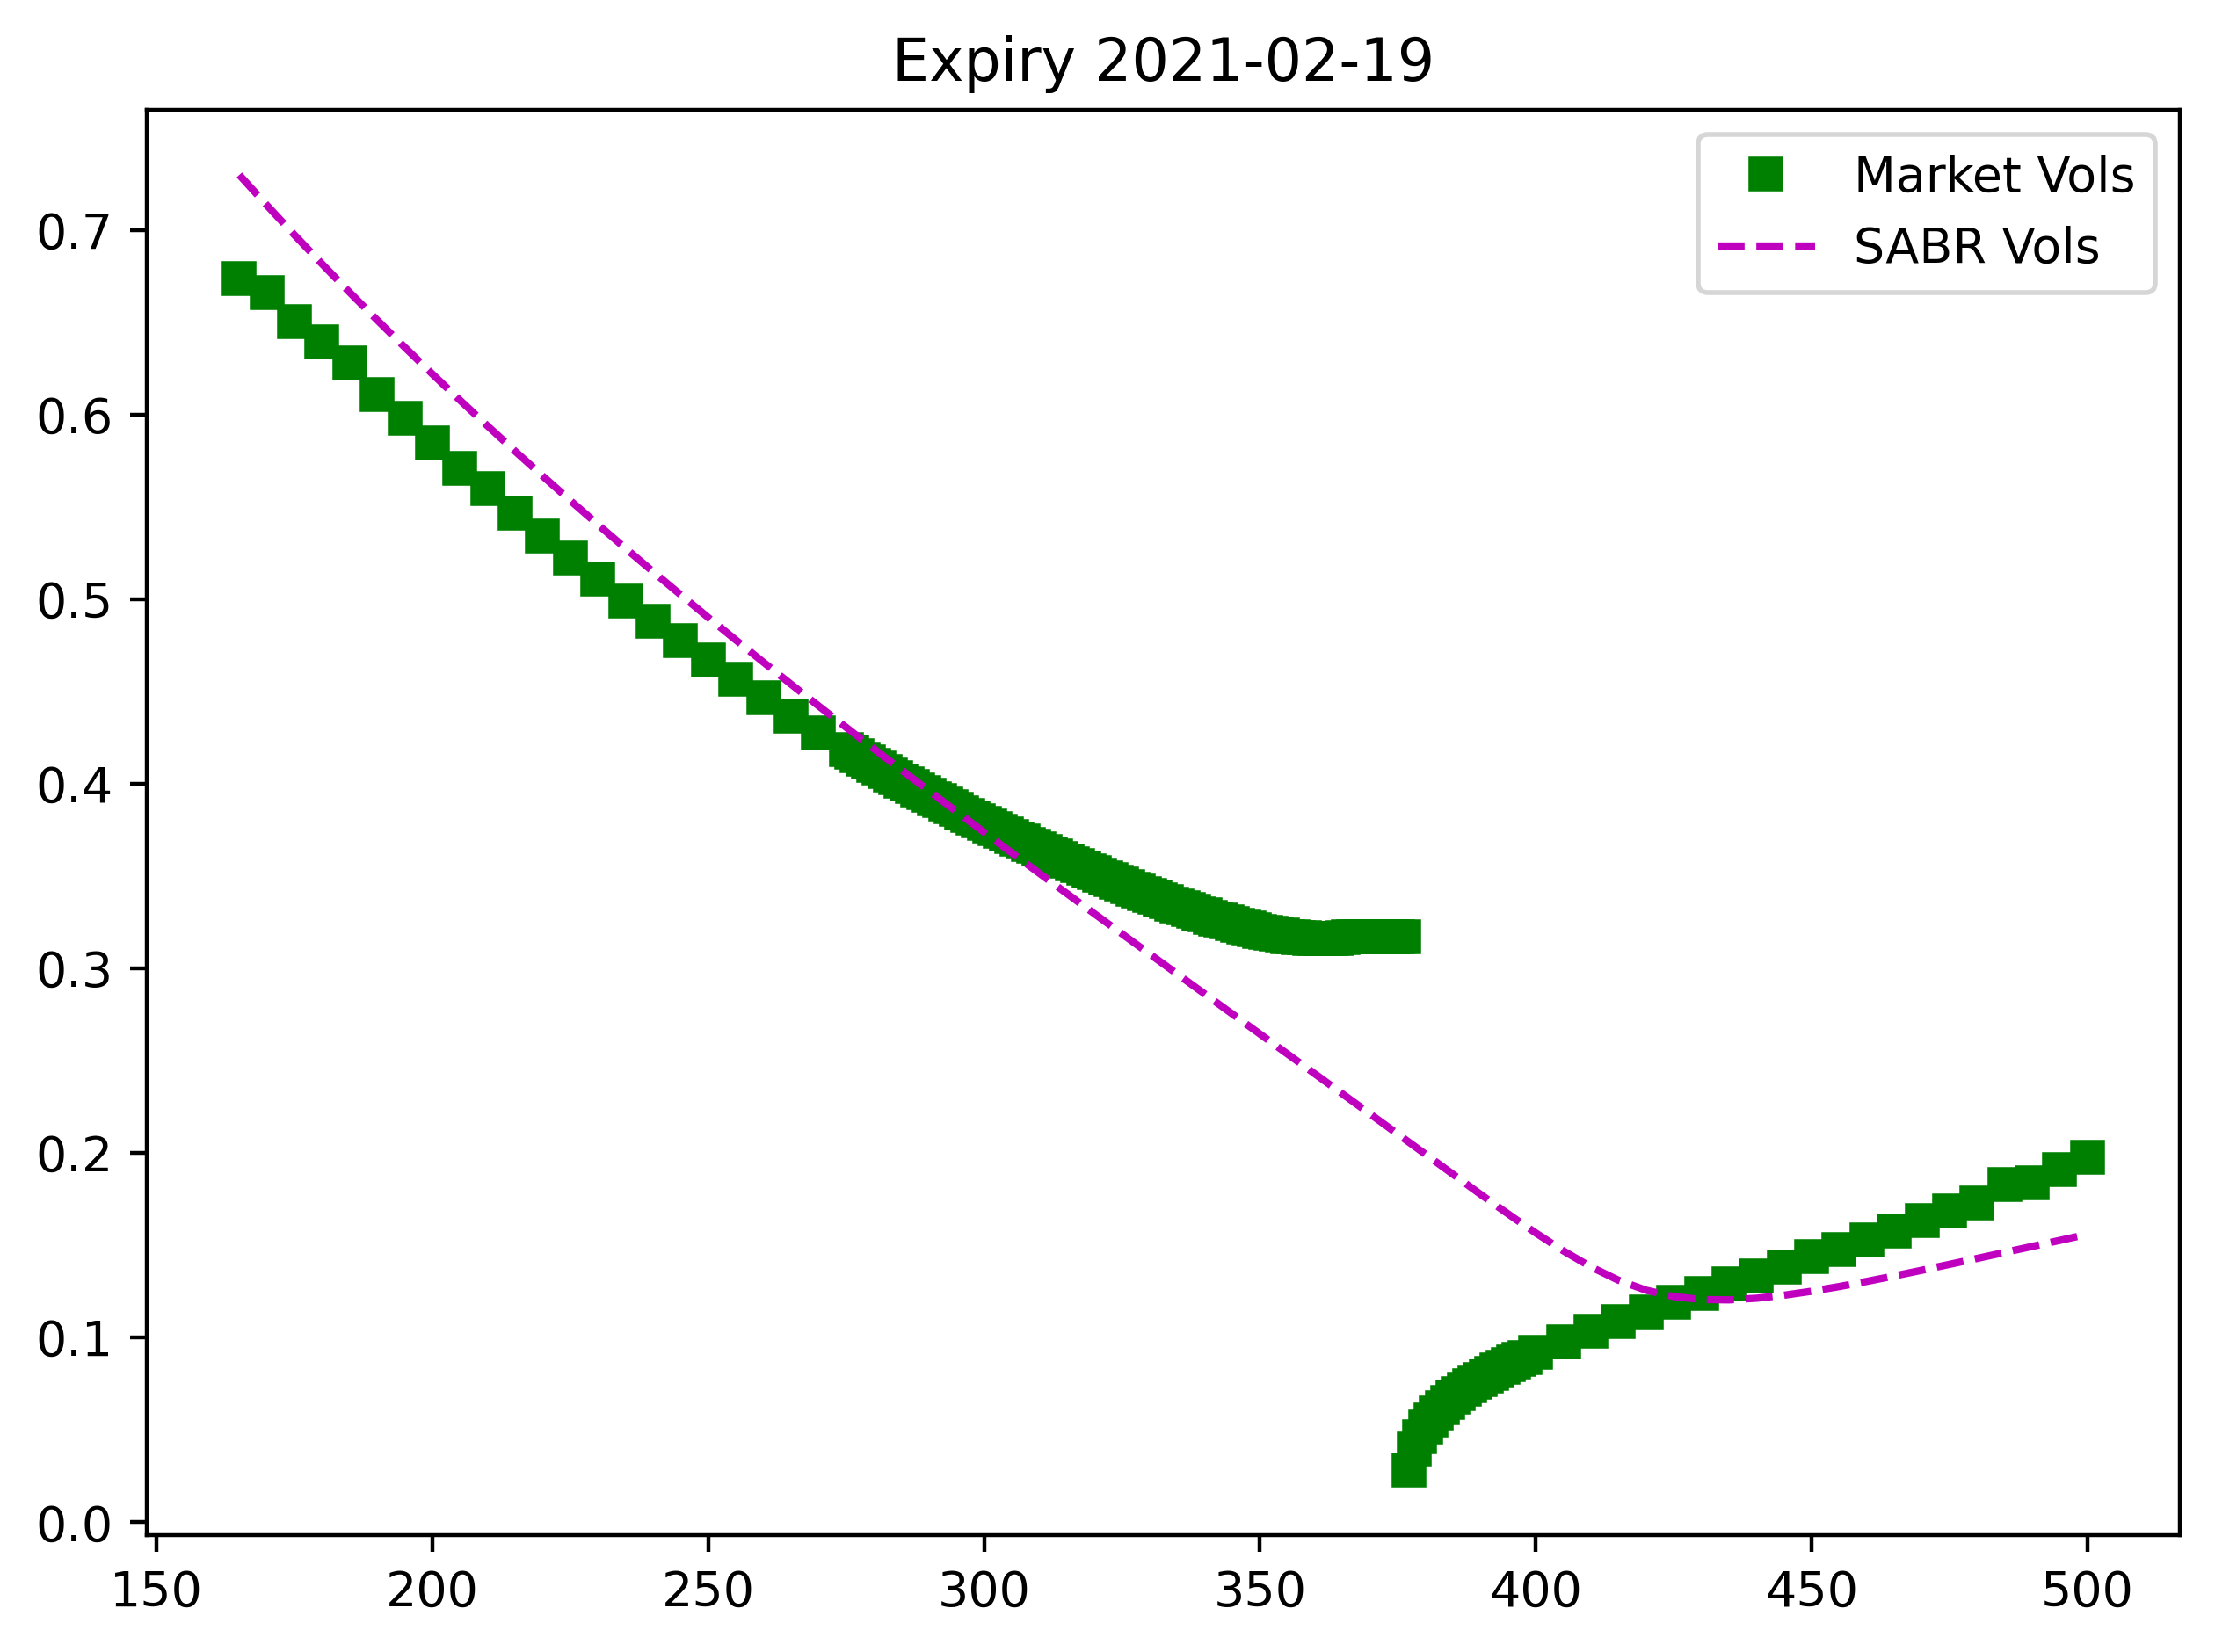

In [19]:
exdate = 20210219 #third expiry
alpha, rho, nu, strikes = calibrate(spy, exdate, S)

## Displaced Diffusion Model

In [20]:
# To calculate the pricing error between the market and displaced diffusion model
def displacedDiffusionCalibration(x, df, F, T, r):
    err = 0.0

    for i, price in enumerate(df['mid']):
        if(df['payoff'][i].lower() == 'call'):
            err += ((df['mid'][i] - displacedDiffusionCall(F, df['strike'][i], x[0], T, r, x[1]))**2)
        else:
            err += ((df['mid'][i] - displacedDiffusionPut(F, df['strike'][i], x[0], T, r, x[1]))**2)

    return err

In [21]:
# Option pricing formula
def displacedDiffusionCall(F, K, sigma, T, r, beta):
    F = F/beta
    K = K + ((1-beta)/beta)*F
    sigma = sigma*beta
    
    d1 = (np.log(F/K) + (sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)    
    return np.exp(-r * T)*(F * N_d1 - K * N_d2)

def displacedDiffusionPut(F, K, sigma, T, r, beta):
    F = F/beta
    K = K + ((1-beta)/beta)*F
    sigma = sigma*beta
    
    d1 = (np.log(F/K) + (sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    
    N_d1 = norm.cdf(-d1)
    N_d2 = norm.cdf(-d2)    
    return np.exp(-r * T)*(K * N_d2 - F * N_d1)

In [22]:
def calibrateDD(df, exdate, S):
    #extract data for given expiry
    df = df[df['exdate'] == exdate]
    
    days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
    T = days_to_expiry/365
    
    #interpolate the rate
    r = np.interp(days_to_expiry, discount_rate['days'], discount_rate['rate'])
    
    #Calculate Forward rate
    F = S*np.exp(r*T)
    
    #calibrate the parameters to match the market price
    initialGuess = [0.02, 0.7]
    res = least_squares(lambda x: displacedDiffusionCalibration(x,
                                                                df,
                                                                F,
                                                                T,
                                                                r),
                                                                initialGuess)
    
    #calculate option price using calibrated parameters
    sigma = res.x[0]
    beta = res.x[1]
    df['dd_price'] = 0
    for i, strike in enumerate(df['strike']):
        if df['payoff'][i].lower() == 'call':
            df['dd_price'][i] = displacedDiffusionCall(F,strike,sigma,T,r,beta)
        else:
            df['dd_price'][i] = displacedDiffusionPut(F,strike,sigma,T,r,beta)
    
    #Implied Volatility based on Diffusion price
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                x['strike'],
                                                r,
                                                x['dd_price'],
                                                T,
                                                x['payoff']),
                                                axis=1)
    
    #Implied Volatility based on market price
    df['market_vols'] = df.apply(lambda x: impliedVolatility(S,
                                                x['strike'],
                                                r,
                                                x['mid'],
                                                T,
                                                x['payoff']),
                                                axis=1)
    
    df.dropna(inplace=True)
    
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    
    #Store the out of money option implied volatilities 
    dd_vols = []
    market_vols = []
    for K in strikes:
        try:
            if K > S:
                dd_vols.append(call_df[call_df['strike'] == K]['vols'].values[0])
                market_vols.append(call_df[call_df['strike'] == K]['market_vols'].values[0])
            else:
                dd_vols.append(put_df[put_df['strike'] == K]['vols'].values[0])
                market_vols.append(put_df[put_df['strike'] == K]['market_vols'].values[0])
        except IndexError:
            dd_vols.append(None)
            market_vols.append(None)
            

    #populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'dd_vol': dd_vols, 'market_vol':market_vols})
    df.ffill(inplace=True)
    
    #Calibrated Parameters
    print('Beta :',beta)
    print('sigma :',sigma)
    
    #Plot the volatility smile
    plt.figure(tight_layout=True,dpi=400)
    plt.plot(strikes, df['market_vol'], 'gs', label='Market Vols')
    plt.plot(strikes, df['dd_vol'], 'm--', label='Displaced Diffusion Vols')
    plt.title(f'Expiry {pd.Timestamp(str(exdate)).date()}')
    plt.legend()
    plt.show()
    
    return strikes

In [23]:
S = 3662.45

In [24]:
spx.exdate.value_counts()

exdate
20201218    822
20210115    738
20210219    512
Name: count, dtype: int64

Beta : 0.9367989454800346
sigma : 0.18333729042540864


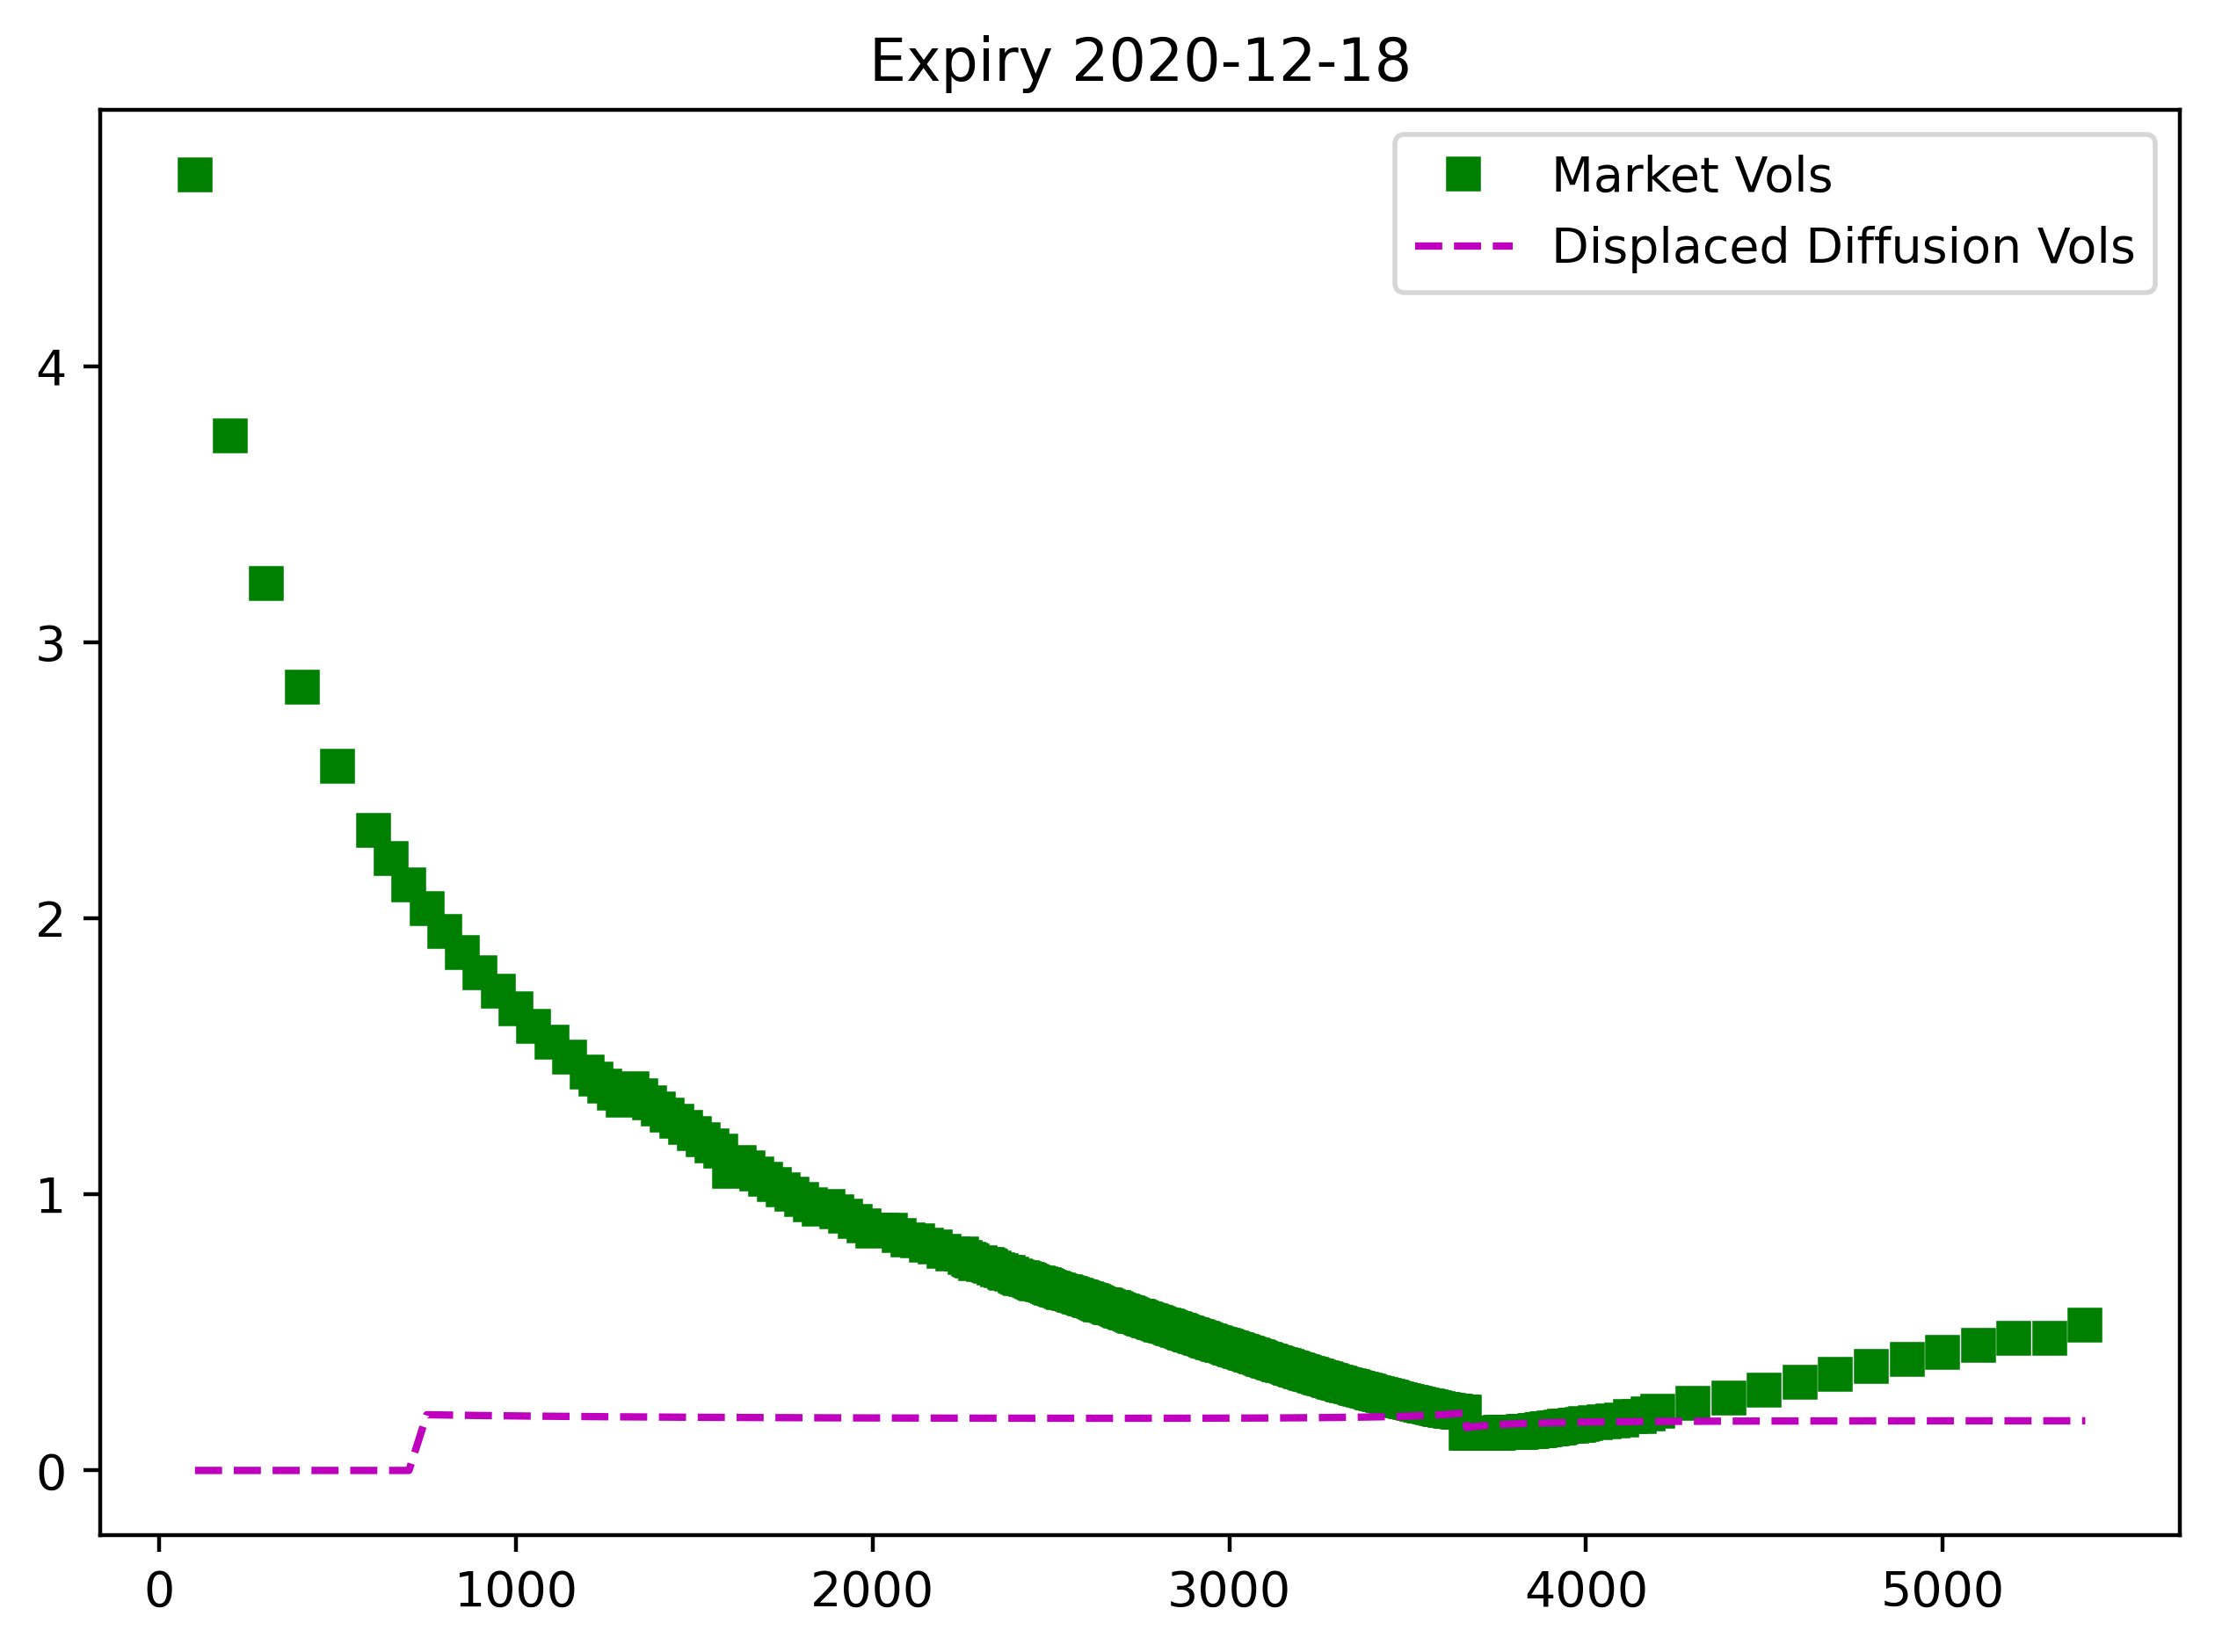

In [25]:
strikes = calibrateDD(spx, 20201218, S)

Beta : 0.878215007509429
sigma : 0.19432713052549952


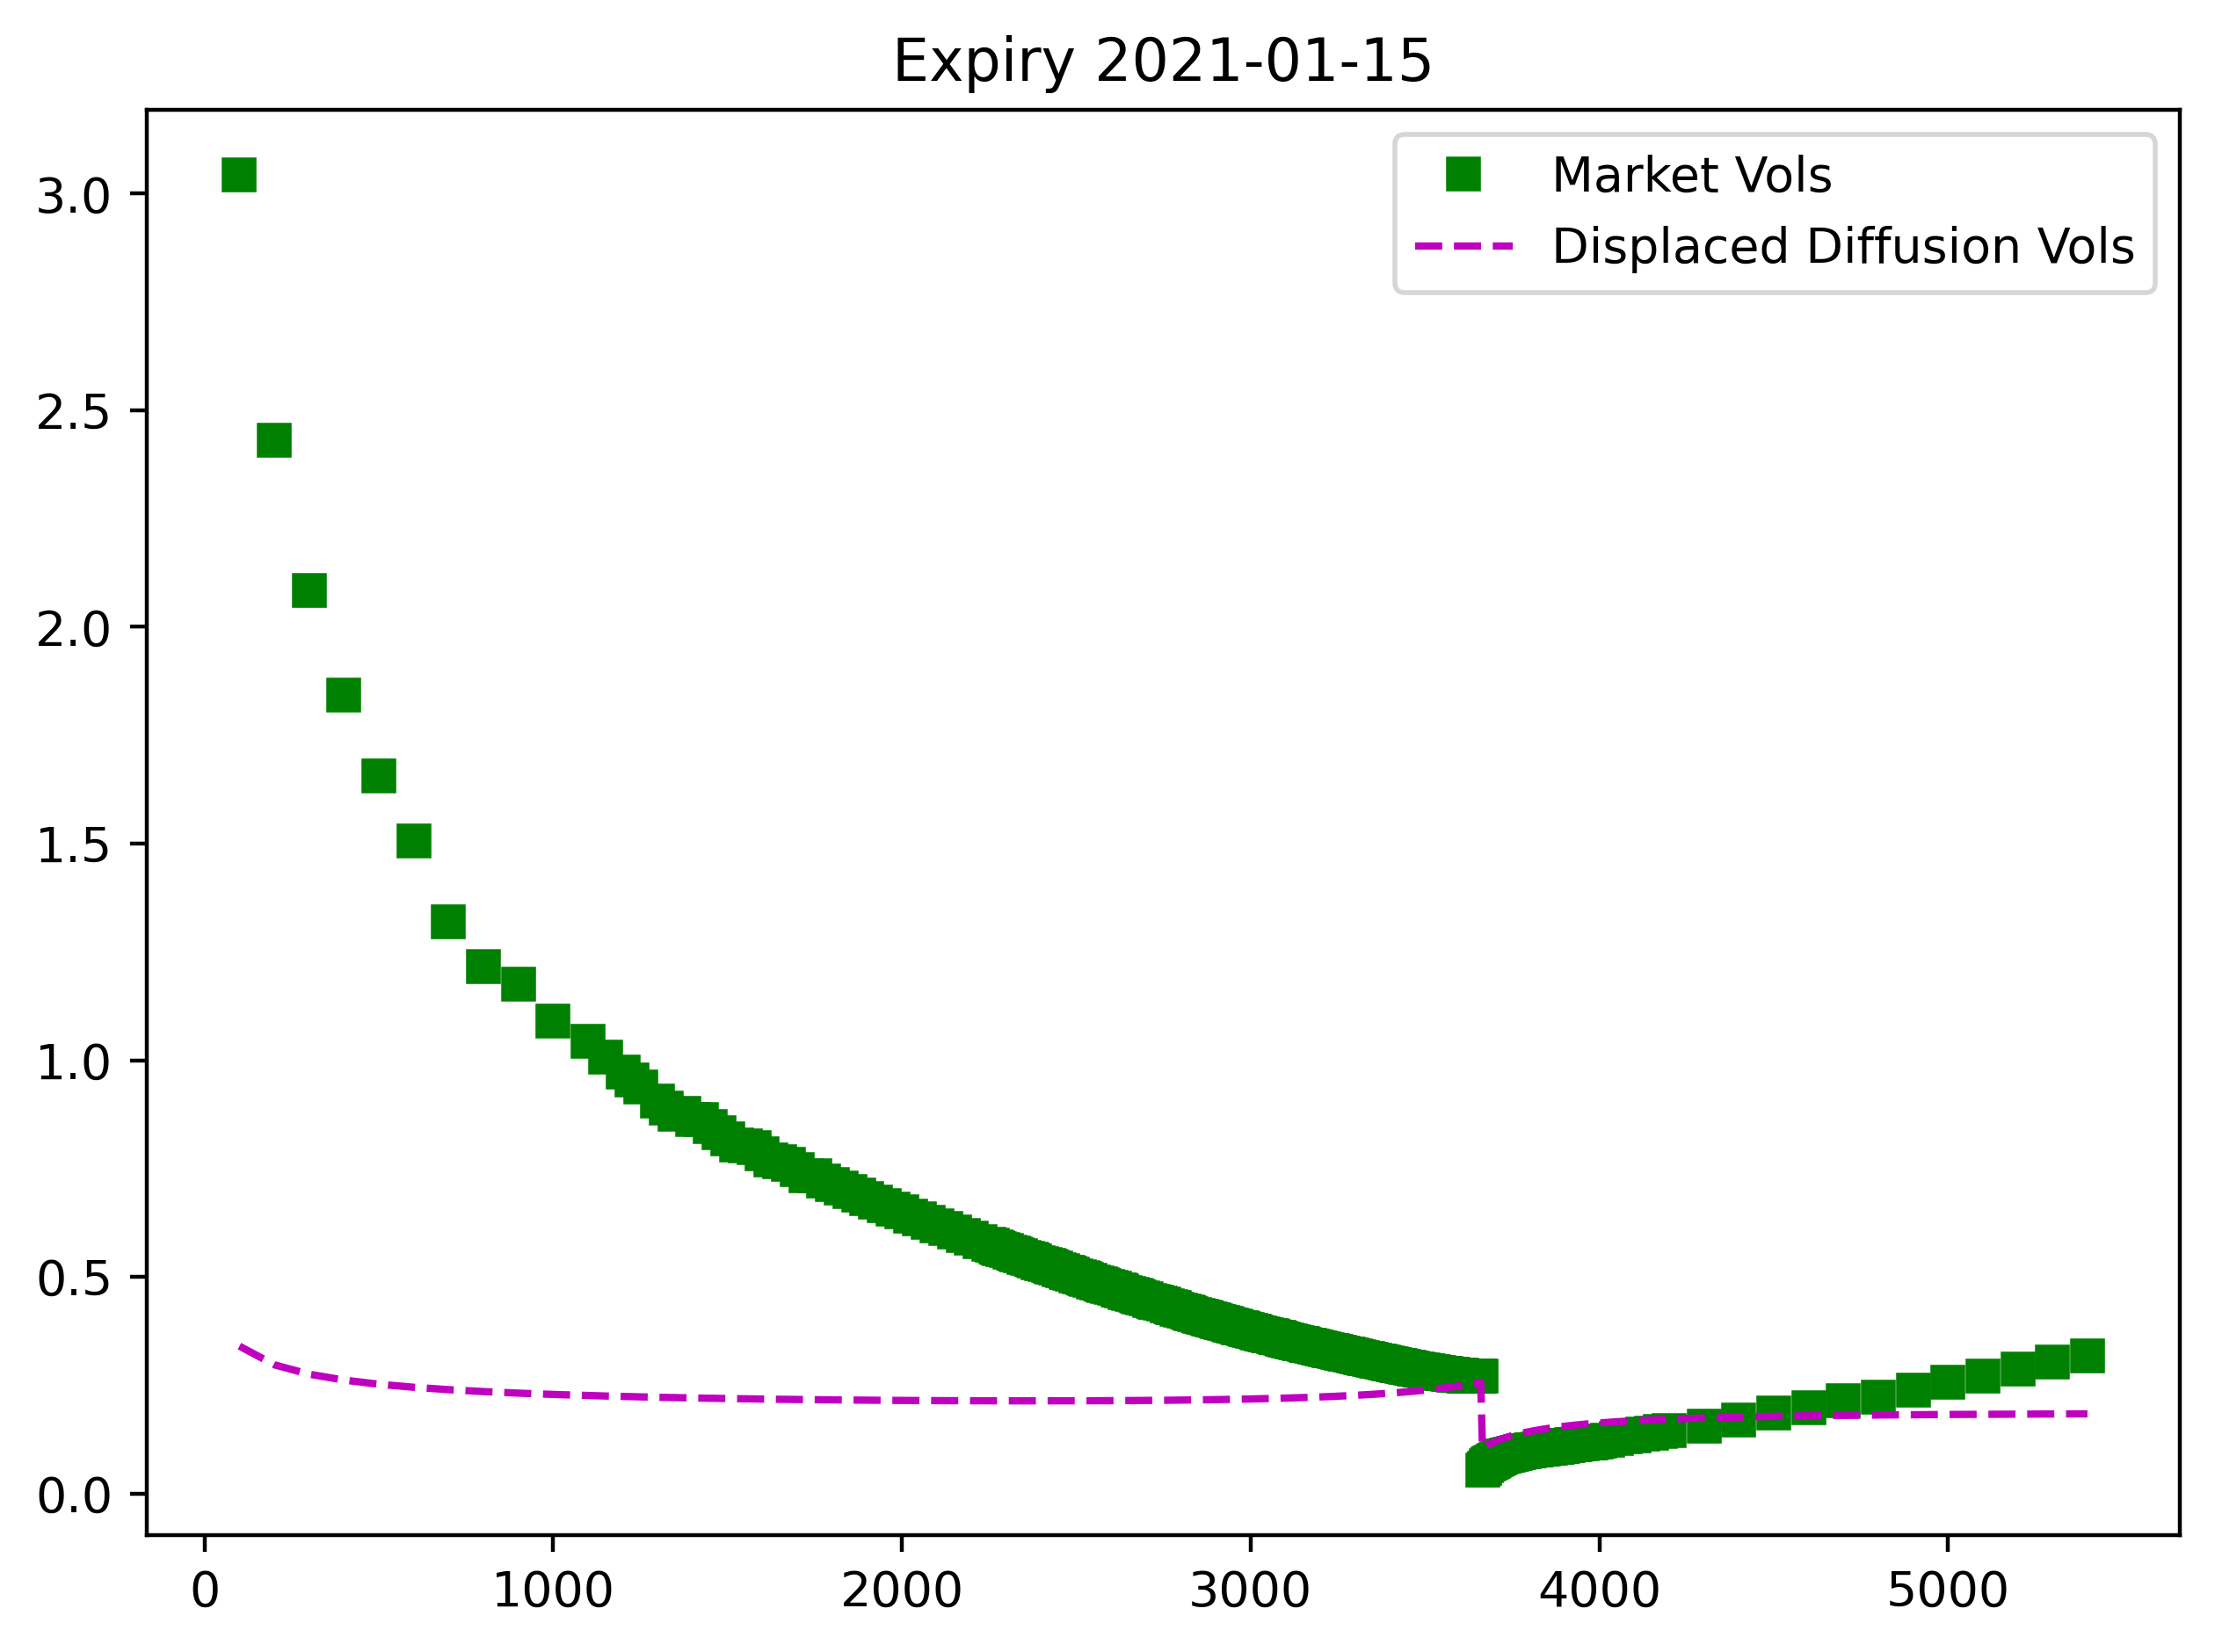

In [26]:
strikes = calibrateDD(spx, 20210115, S)

Beta : 0.8382299452735688
sigma : 0.2023655039360181


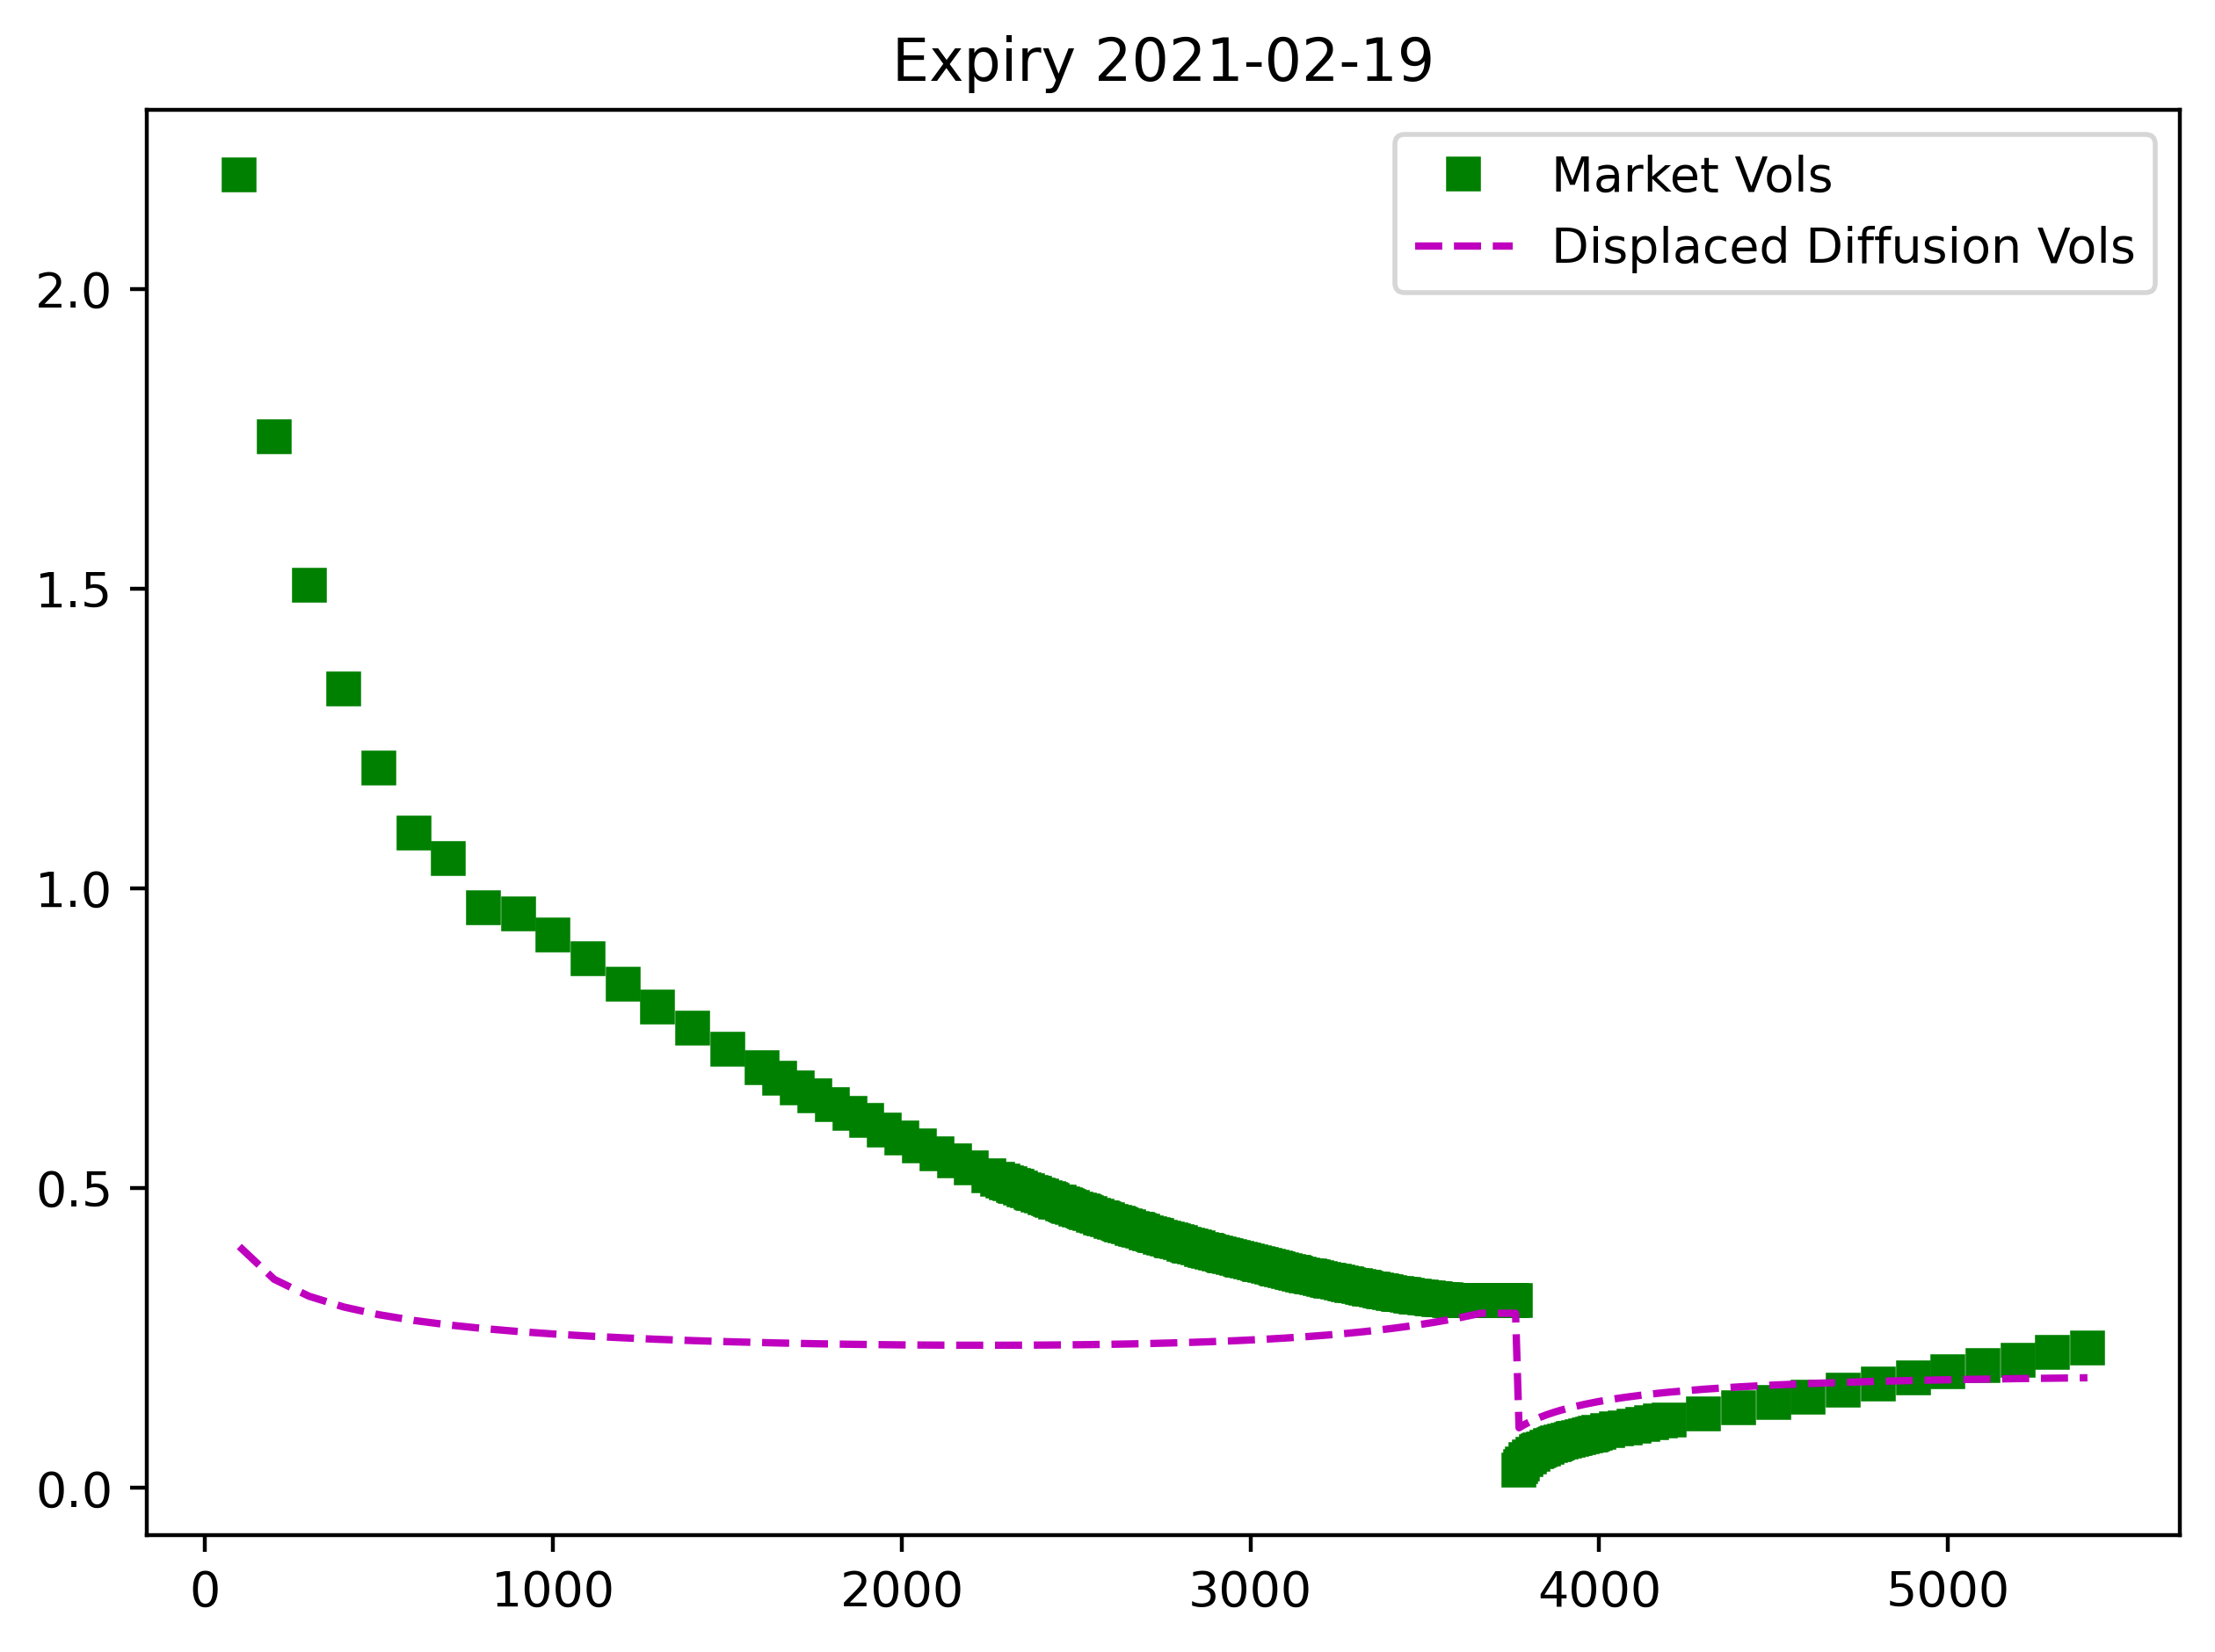

In [27]:
strikes = calibrateDD(spx, 20210219, S)

Let's calibrate using SPY data now:

In [28]:
spy.exdate.value_counts()

exdate
20210115    556
20201218    510
20210219    334
Name: count, dtype: int64

In [29]:
S = 366.02

Beta : 0.876404493403587
sigma : 0.19854602476455005


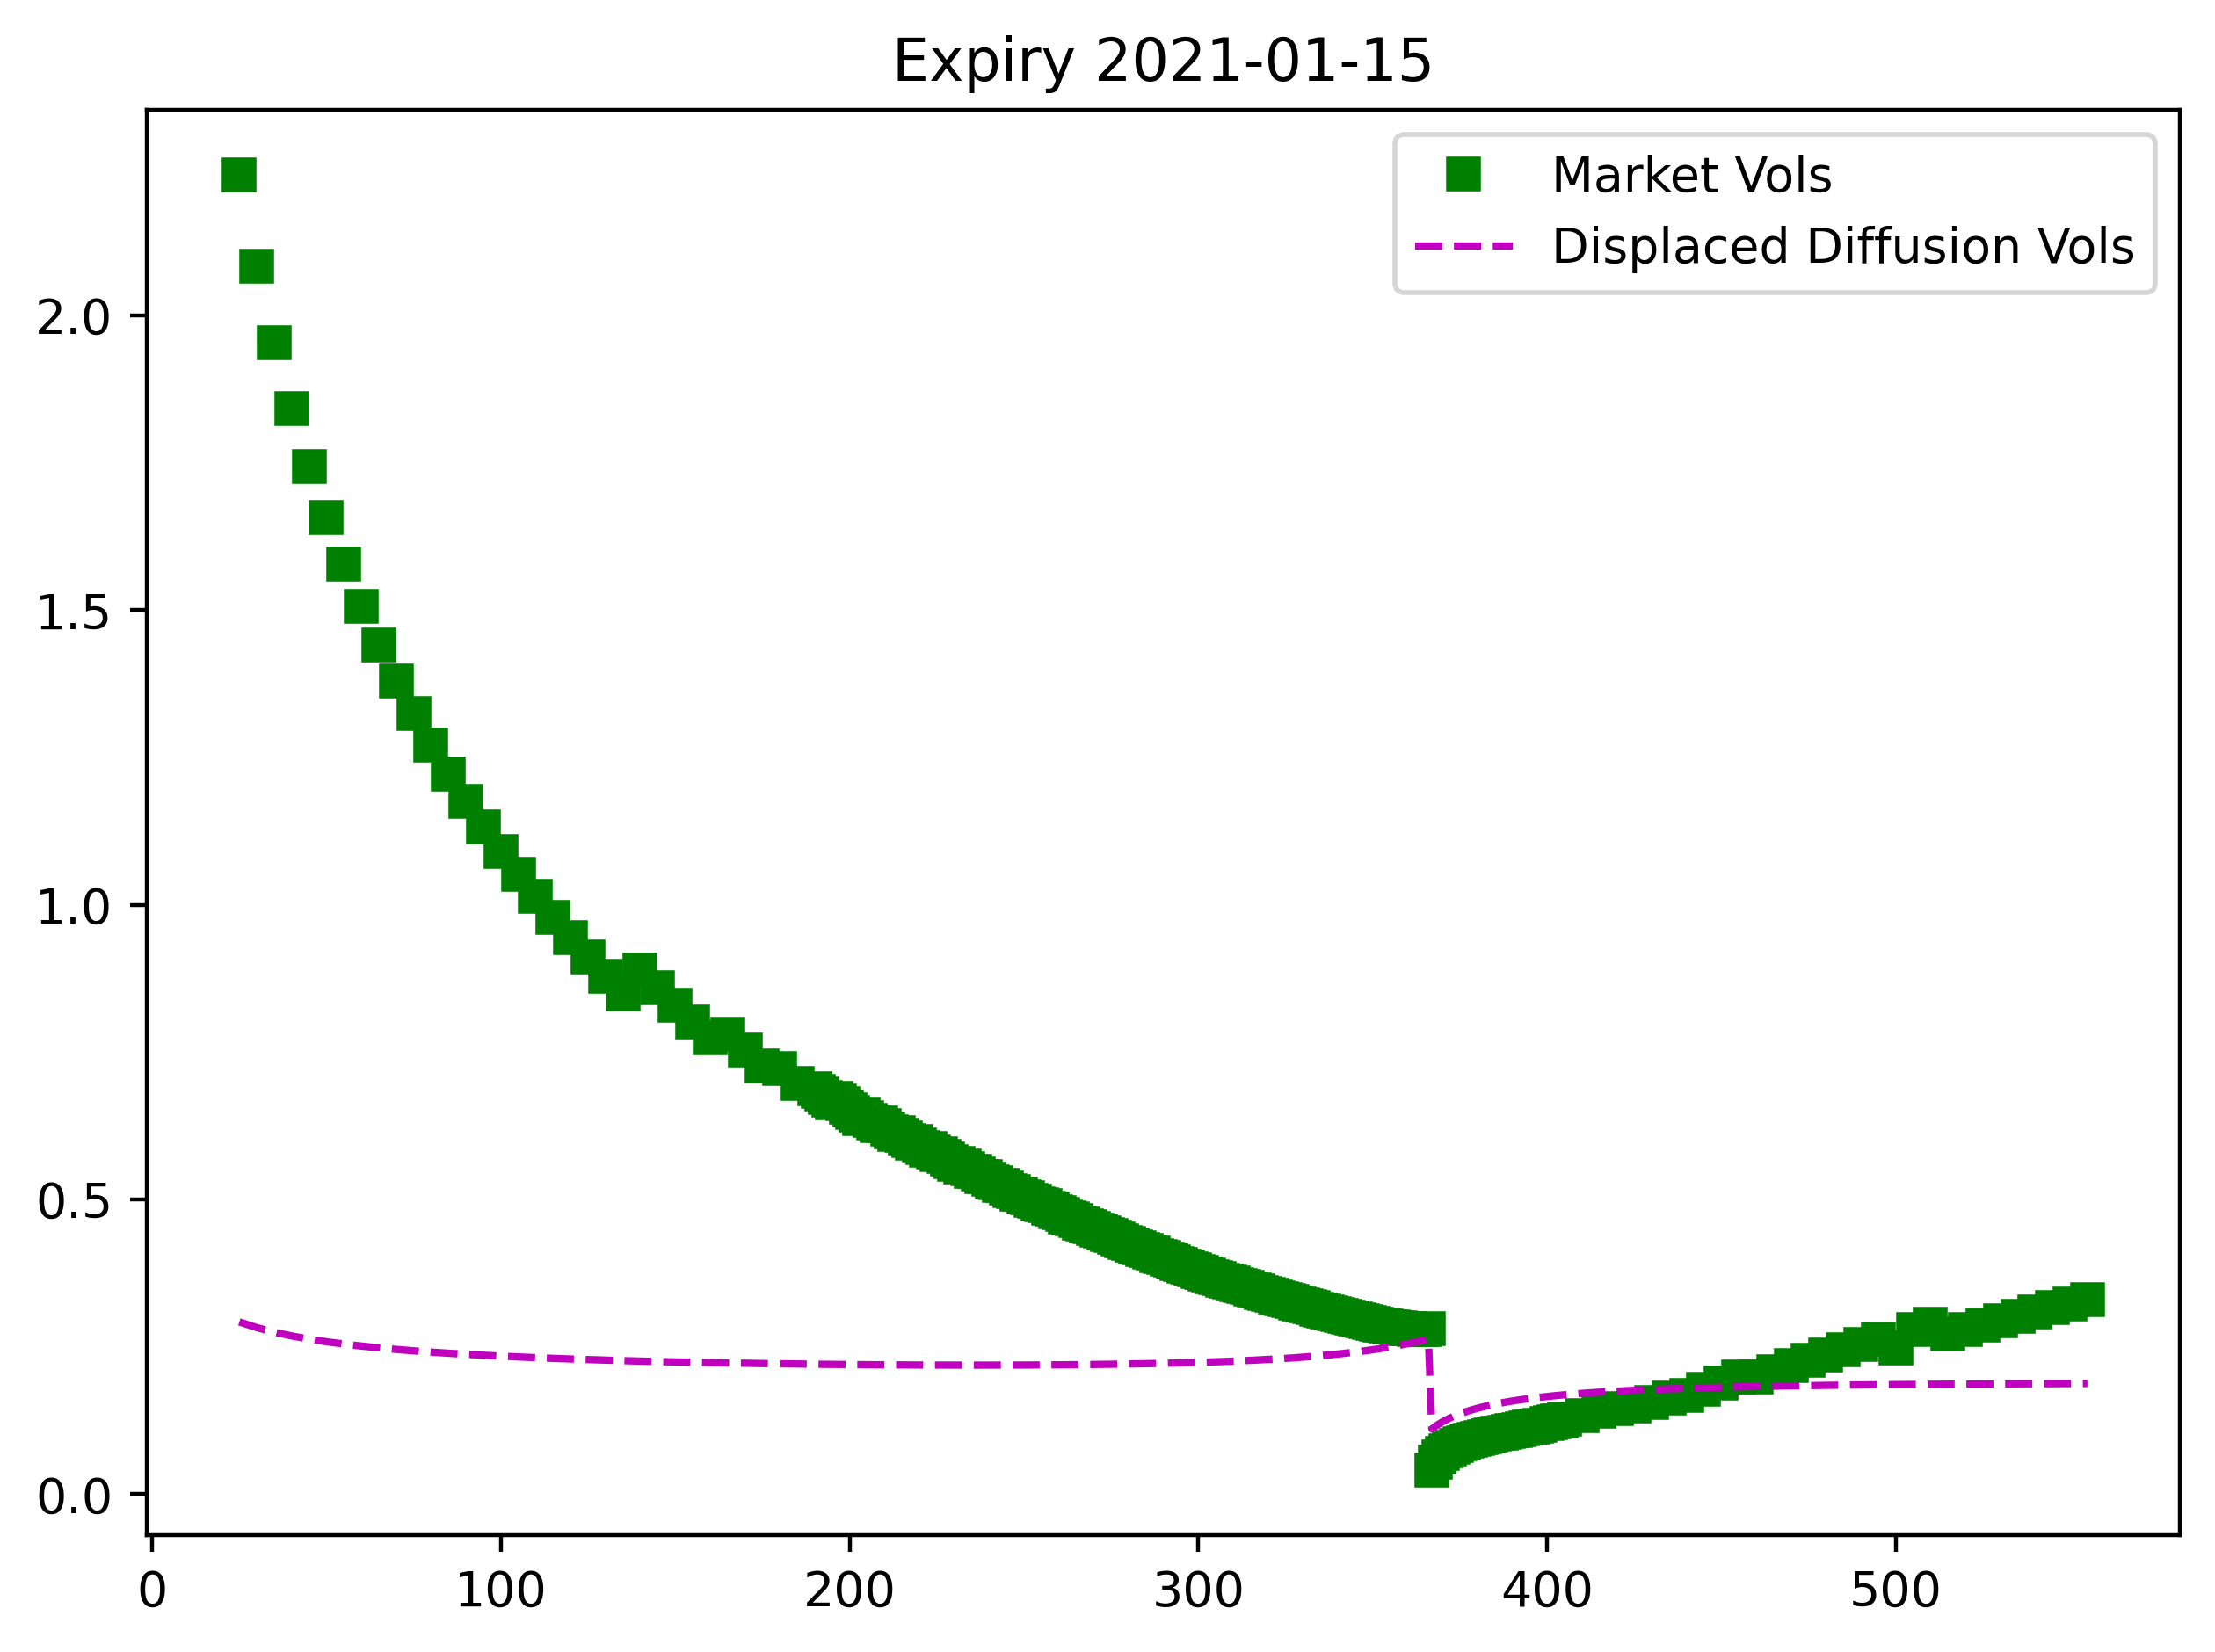

In [30]:
strikes = calibrateDD(spy, 20210115, S)

Beta : 0.9328517821926869
sigma : 0.20328017038046914


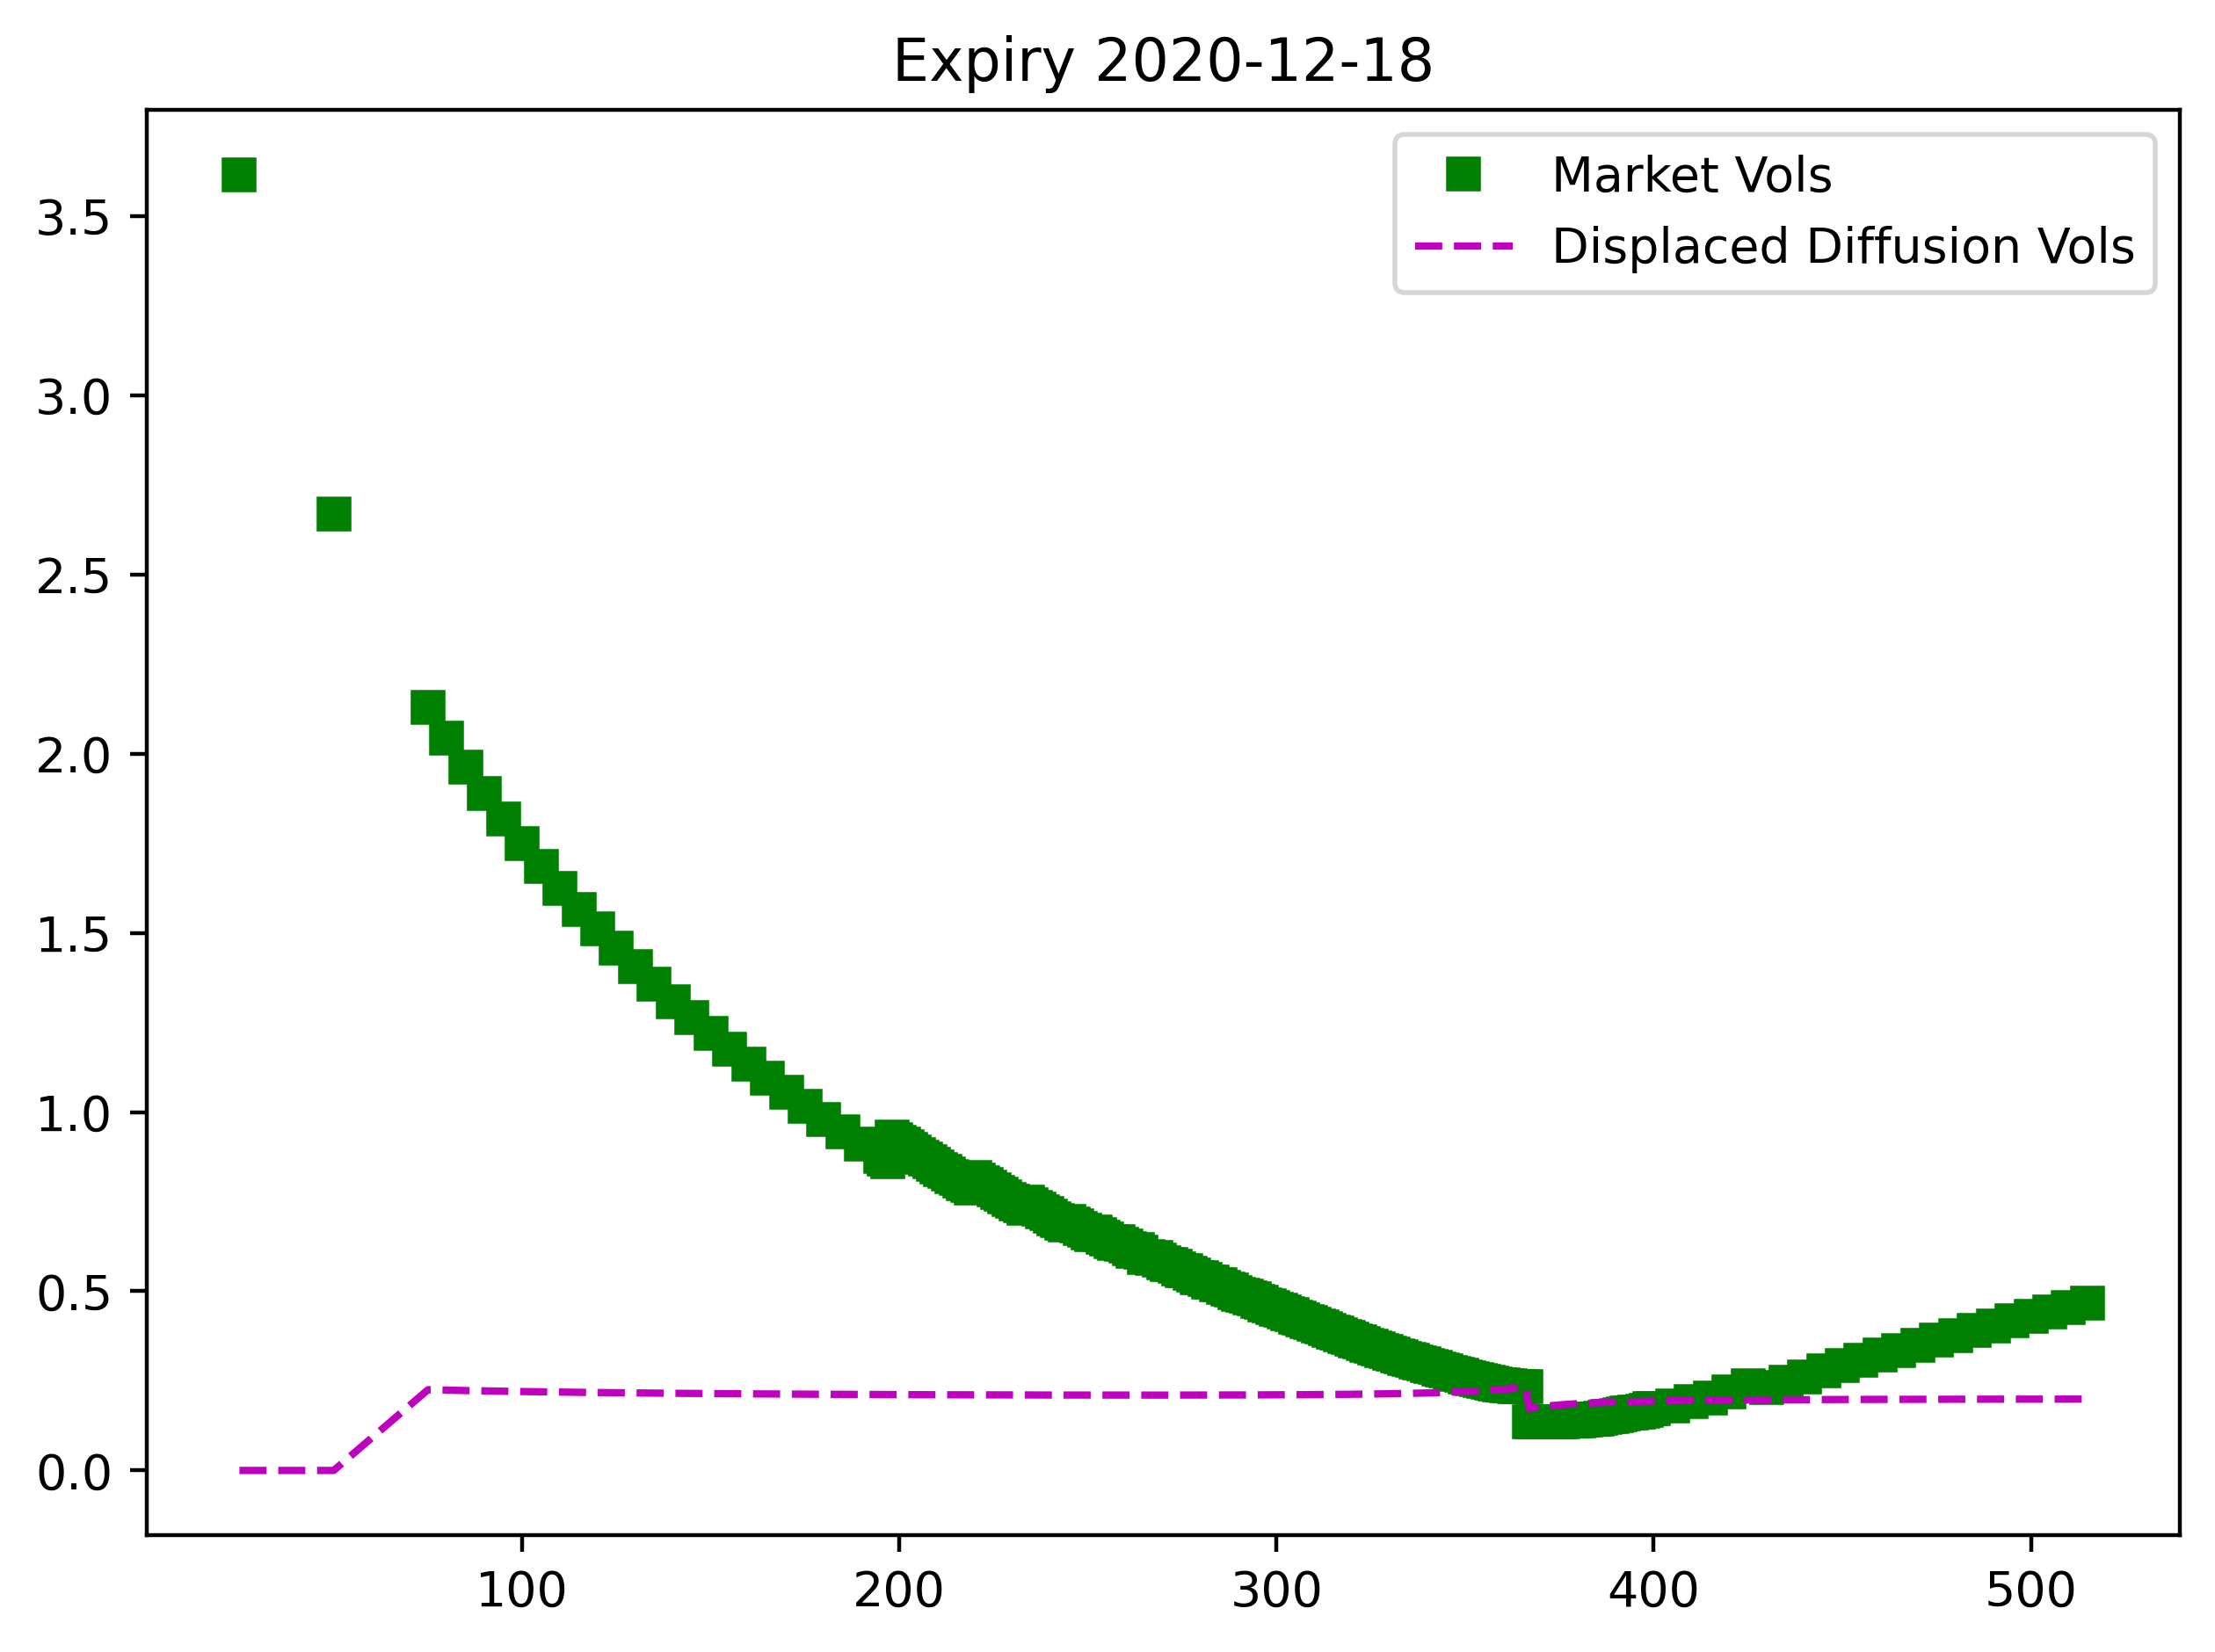

In [31]:
strikes = calibrateDD(spy, 20201218, S)

Beta : 1.2564873232265947
sigma : 0.20640263684159202


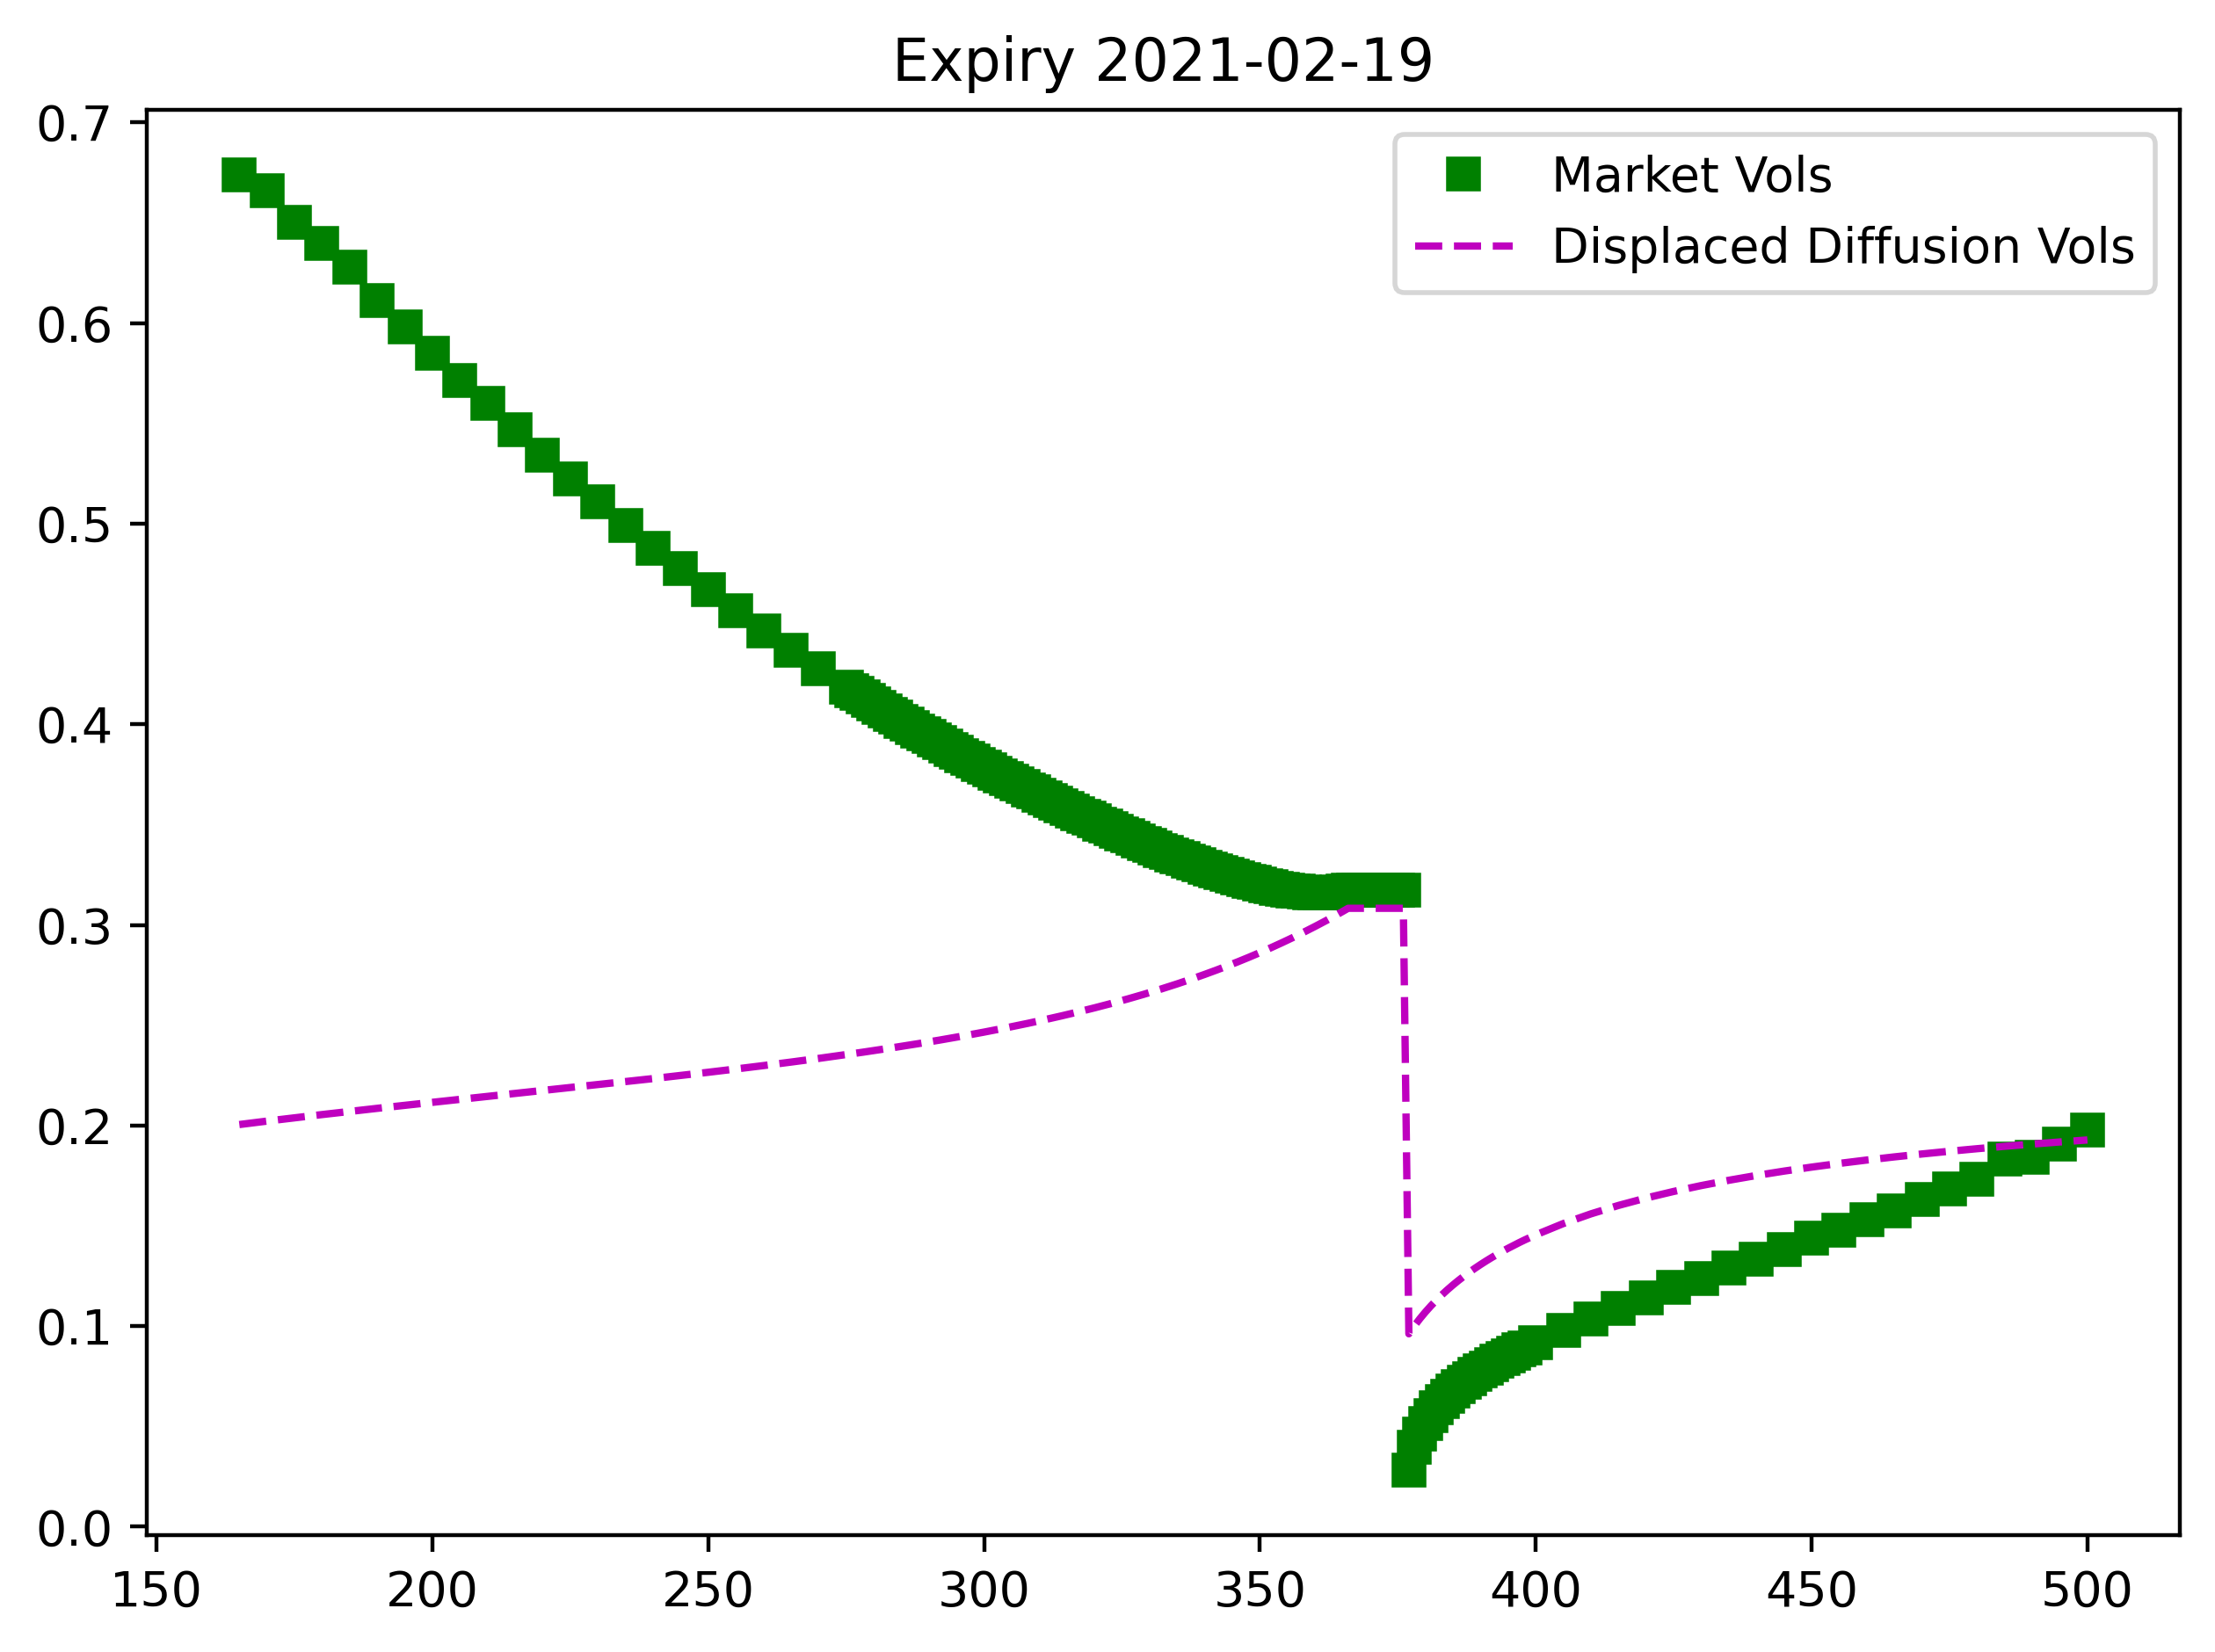

In [32]:
strikes = calibrateDD(spy, 20210219, S)

## Model Parameter Sensitivity

In [33]:
# Displaced-Diffusion Model
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

In [36]:
S = 3662.45

days_to_expiry = (pd.Timestamp(str(20201218)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365

r = np.interp(days_to_expiry, discount_rate['days'], discount_rate['rate'])

F = S*np.exp(r*T)

sigma = 0.18333
beta = 0.1

In [37]:
dd_df = spx[spx.exdate == 20201218]

In [38]:
call_df = dd_df[dd_df['cp_flag'] == 'C']
put_df = dd_df[dd_df['cp_flag'] == 'P']
strikes = put_df['strike'].values

In [39]:
summary = []
for i in range(len(put_df.index)):
    K = strikes[i]
    if K <= 3660:
        impliedvol_market = impliedVolatility(S, K, r, put_df['mid'][i], T, 'put')
        
        price_dd = DisplacedDiffusionPut(S, K, r, sigma, T, 0.1)
        impliedvol_dd1 = impliedVolatility(S, K, r, price_dd, T,'put')
        
        price_dd = DisplacedDiffusionPut(S, K, r, sigma, T, 0.3)
        impliedvol_dd2 = impliedVolatility(S, K, r, price_dd, T,'put')
        
        price_dd = DisplacedDiffusionPut(S, K, r, sigma, T, 0.5)
        impliedvol_dd3 = impliedVolatility(S, K, r, price_dd, T,'put')
        
    else:
        impliedvol_market = impliedVolatility(S, K, r, put_df['mid'][i], T, 'call')
        
        price_dd = DisplacedDiffusionCall(S, K, r, sigma, T, 0.1)
        impliedvol_dd1 = impliedVolatility(S, K, r, price_dd, T,'call')
        
        price_dd = DisplacedDiffusionCall(S, K, r, sigma, T, 0.3)
        impliedvol_dd2 = impliedVolatility(S, K, r, price_dd, T,'call')
        
        price_dd = DisplacedDiffusionCall(S, K, r, sigma, T, 0.5)
        impliedvol_dd3 = impliedVolatility(S, K, r, price_dd, T,'call')
        
    summary.append([K,
                     impliedvol_market,
                     impliedvol_dd1,
                   impliedvol_dd2,
                   impliedvol_dd3])

dd = pd.DataFrame(summary, columns=['strike', 
                                   'impliedvol_market', 
                                   'impliedvol_dd1',
                                   'impliedvol_dd2',
                                   'impliedvol_dd3'])

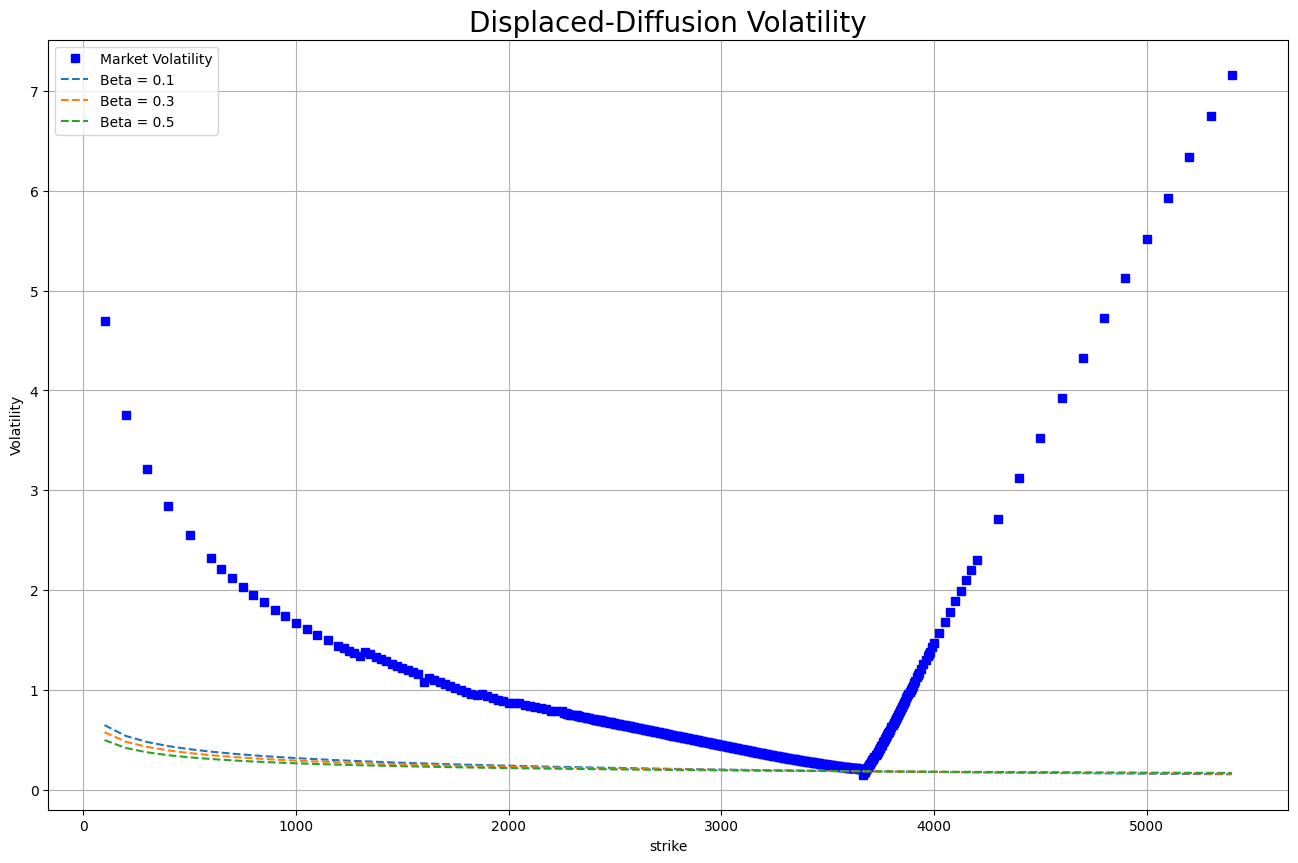

In [40]:
plt.figure(figsize=(16 , 10))
plt.plot(dd['strike'], dd['impliedvol_market'], 'bs', label = 'Market Volatility')
sns.lineplot(x = dd['strike'], y = dd['impliedvol_dd1'], label = 'Beta = 0.1', linestyle = '--')
sns.lineplot(x = dd['strike'], y = dd['impliedvol_dd2'], label = 'Beta = 0.3', linestyle = '--')
sns.lineplot(x = dd['strike'], y = dd['impliedvol_dd3'], label = 'Beta = 0.5', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.grid()
plt.show()

In [41]:
# Rho adjustment

F = np.exp(r*T)*S

In [42]:
dd_3 = dd

In [43]:
#Calibrated SABR model parameters:
alpha = 1.211
beta = 0.7
#rho = -0.364
nu = 5.452

In [44]:
SABR_rho =[]
for rho in np.arange(-0.75,1,0.25):
    SABR_vol = []
    for K in dd['strike']:
        SABR_vol.append(SABR(F, K, T, alpha, beta, rho, nu))
    SABR_rho.append(SABR_vol)

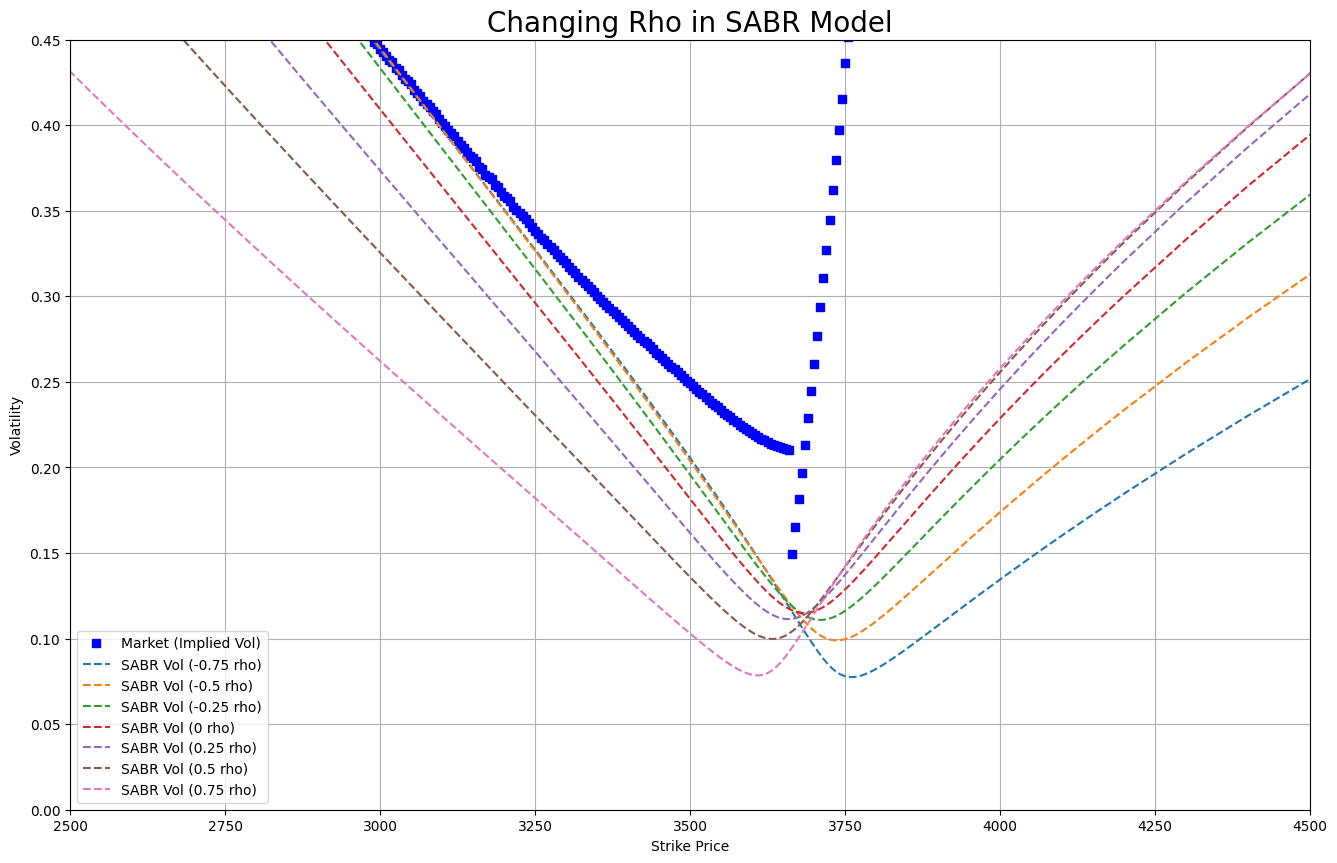

In [45]:
plt.figure(figsize=(16 , 10))
plt.plot(dd_3['strike'], dd_3['impliedvol_market'], 'bs', label='Market (Implied Vol)')
sns.lineplot(x = dd_3['strike'], y = SABR_rho[0], label = 'SABR Vol (-0.75 rho)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_rho[1], label = 'SABR Vol (-0.5 rho)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_rho[2], label = 'SABR Vol (-0.25 rho)', linestyle = '--')

sns.lineplot(x = dd_3['strike'], y = SABR_rho[3], label = 'SABR Vol (0 rho)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_rho[4], label = 'SABR Vol (0.25 rho)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_rho[5], label = 'SABR Vol (0.5 rho)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_rho[6], label = 'SABR Vol (0.75 rho)', linestyle = '--')


plt.legend()
plt.title('Changing Rho in SABR Model', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.xlabel('Strike Price')
plt.ylim(0,0.45)
plt.xlim(2500,4500)


plt.grid()
plt.show()

In [46]:
#Calibrated SABR model parameters:
alpha = 1.211
beta = 0.7
rho = -0.364
#nu = 5.452

In [47]:
#Nu Adjustment
SABR_nu =[]
for nu in np.arange(1,7,1):
    SABR_vol = []
    for K in dd_3['strike']:
        SABR_vol.append(SABR(F, K, T, alpha, beta, rho, nu))
    SABR_nu.append(SABR_vol)

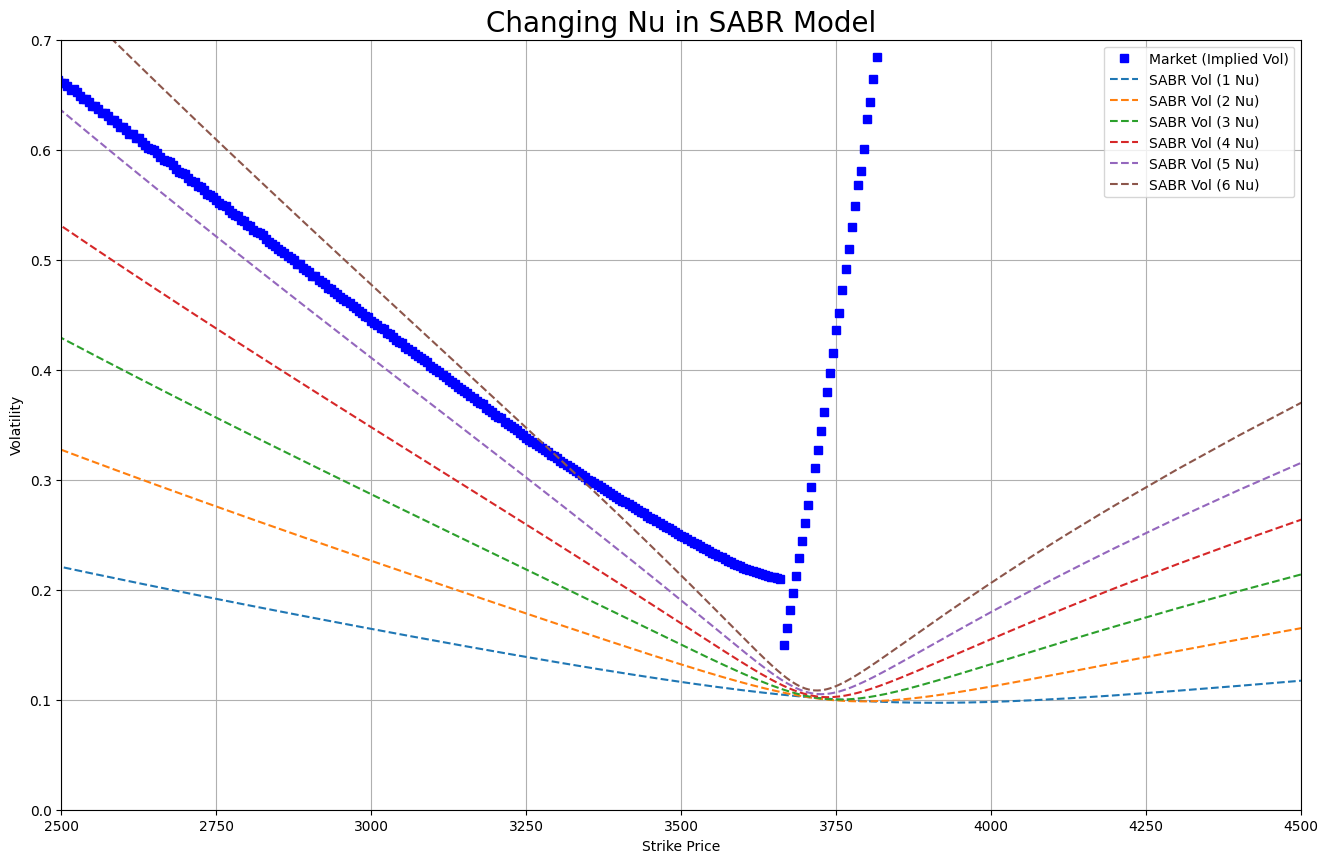

In [48]:
plt.figure(figsize=(16 , 10))
plt.plot(dd_3['strike'], dd_3['impliedvol_market'], 'bs', label='Market (Implied Vol)')
sns.lineplot(x = dd_3['strike'], y = SABR_nu[0], label = 'SABR Vol (1 Nu)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_nu[1], label = 'SABR Vol (2 Nu)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_nu[2], label = 'SABR Vol (3 Nu)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_nu[3], label = 'SABR Vol (4 Nu)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_nu[4], label = 'SABR Vol (5 Nu)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = SABR_nu[5], label = 'SABR Vol (6 Nu)', linestyle = '--')

plt.legend()
plt.title('Changing Nu in SABR Model', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.xlabel('Strike Price')
plt.ylim(0,0.7)
plt.xlim(2500,4500)


plt.grid()
plt.show()